# Multi‑Modal Retail Product Discovery



In [1]:
import os, sys, subprocess, platform, shutil

def pip_install(pkgs):
    cmd = [sys.executable, "-m", "pip", "install", "-q", "--upgrade"] + pkgs
    print("Installing:", " ".join(pkgs))
    subprocess.check_call(cmd)

def has_cmd(cmd: str) -> bool:
    return shutil.which(cmd) is not None

IN_COLAB = "COLAB_RELEASE_TAG" in os.environ
print("Python:", sys.version)
print("Platform:", platform.platform())
print("Running in Colab:", IN_COLAB)


try:
    import torch, torchvision
    print("Torch:", torch.__version__)
except Exception as e:
    print("Torch not found (or broken). Installing CPU torch/torchvision...")
    pip_install(["torch", "torchvision", "torchaudio"])
    import torch, torchvision
    print("Torch:", torch.__version__)


if has_cmd("ffmpeg"):
    print("ffmpeg: found")
else:
    if IN_COLAB and has_cmd("apt-get"):
        print("Installing ffmpeg via apt-get (Colab)...")
        subprocess.check_call(["bash", "-lc", "apt-get -qq update && apt-get -qq install -y ffmpeg"])
    else:
        print("ffmpeg: NOT found. Audio transcription will be disabled until ffmpeg is installed.")
        print("  - macOS: brew install ffmpeg")
        print("  - Ubuntu/Debian: sudo apt-get install ffmpeg")
        print("  - Windows: install ffmpeg and add it to PATH")

pip_install([
    "numpy>=1.24",
    "pandas>=2.0",
    "matplotlib>=3.7",
    "scikit-learn>=1.3",
    "transformers>=4.41.0",
    "datasets>=2.19.0",
    "accelerate>=0.30.0",
    "evaluate>=0.4.2",
    "librosa>=0.10.2",
    "soundfile>=0.12.1",
    "jiwer>=3.0.4",
    "openai-whisper>=20231117",
    "streamlit>=1.33.0",
    "opencv-python-headless>=4.8.0.76",
    "tqdm>=4.66.0",
    "Pillow>=10.0.0",
])

print("✅ Environment ready.")


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Running in Colab: True
Torch: 2.9.0+cu126
ffmpeg: found
Installing: numpy>=1.24 pandas>=2.0 matplotlib>=3.7 scikit-learn>=1.3 transformers>=4.41.0 datasets>=2.19.0 accelerate>=0.30.0 evaluate>=0.4.2 librosa>=0.10.2 soundfile>=0.12.1 jiwer>=3.0.4 openai-whisper>=20231117 streamlit>=1.33.0 opencv-python-headless>=4.8.0.76 tqdm>=4.66.0 Pillow>=10.0.0
✅ Environment ready.


In [2]:
import os, random, json, shutil
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

IN_COLAB = "COLAB_RELEASE_TAG" in os.environ
BASE_DIR = Path("/content") if IN_COLAB else Path.cwd()

PROJECT_DIR = BASE_DIR / "mm_retail_bot"
DATA_DIR    = PROJECT_DIR / "data"
ART_DIR     = PROJECT_DIR / "artifacts"
UI_DIR      = PROJECT_DIR / "ui"

for d in [PROJECT_DIR, DATA_DIR, ART_DIR, UI_DIR]:
    d.mkdir(parents=True, exist_ok=True)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)
print("Project:", PROJECT_DIR)

def _first_existing(candidates):
    for p in candidates:
        p = Path(p)
        if p.exists():
            return p
    return None


SAMPLE_IMAGE_SRC = _first_existing([
    "/mnt/data/sample_product_image.jpg",
    "/content/sample_product_image.jpg",
    str(Path.cwd() / "sample_product_image.jpg"),
    str(Path.cwd() / "sample_product_image.png"),
])

SAMPLE_AUDIO_SRC = _first_existing([
    "/mnt/data/sample_query_audio.mp3",
    "/content/sample_query_audio.mp3",
    str(Path.cwd() / "sample_query_audio.mp3"),
    str(Path.cwd() / "sample_query_audio.wav"),
])

FASHION_ZIP_SRC = _first_existing([
    "/mnt/data/fashion-mnist-master.zip",
    "/content/fashion-mnist-master.zip",
    str(Path.cwd() / "fashion-mnist-master.zip"),
])

SAMPLE_IMAGE_PATH = DATA_DIR / "sample_product_image.jpg"
SAMPLE_AUDIO_PATH = DATA_DIR / "sample_query_audio.mp3"

print("Sample image src:", SAMPLE_IMAGE_SRC)
print("Sample audio src:", SAMPLE_AUDIO_SRC)
print("Fashion-MNIST zip src:", FASHION_ZIP_SRC)

def show_image_grid(images, titles=None, n=8, figsize=(12,3)):
    n = min(n, len(images))
    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i], cmap="gray" if images[i].ndim==2 else None)
        plt.axis("off")
        if titles:
            plt.title(str(titles[i]), fontsize=9)
    plt.tight_layout()
    plt.show()


Device: cuda
Project: /content/mm_retail_bot
Sample image src: None
Sample audio src: None
Fashion-MNIST zip src: None


In [3]:
from pathlib import Path
import base64, shutil

def _maybe_copy(src, dst: Path) -> bool:
    try:
        if src and Path(src).exists():
            dst.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy2(src, dst)
            return True
    except Exception as e:
        print(f"⚠️ Copy failed {src} -> {dst}: {e}")
    return False

def _write_b64(dst: Path, b64: str):
    dst.parent.mkdir(parents=True, exist_ok=True)
    dst.write_bytes(base64.b64decode(b64))

_EMBED_SAMPLE_IMAGE_B64 = """/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxAQEhIREBAQEBIVEA8QDw8QDw8QDxAQFhUXFhUSFRUYHSggGBolGxUVITEhJSkrLi8yFx8zODUvOSgtLisBCgoKDQ0OFQ8NFSsZFRkrKy0rNysrKzc3Ky0tKysrLTcrLS0tKzcrLSstLS0rKysrLSstKysrNy0rKysrKysrK//AABEIAOEA4QMBIgACEQEDEQH/xAAcAAEAAQUBAQAAAAAAAAAAAAAAAQIDBAcIBgX/xABPEAABAwIDBAYDCQoNBQEAAAABAAIDBBEFEiEGBzFREyJBYXGBFCORMlJiY4KhorHRFSQzNEJEcnSSslNUZHODhJOjs8HC0uEWQ1WU8Aj/xAAVAQEBAAAAAAAAAAAAAAAAAAAAAf/EABQRAQAAAAAAAAAAAAAAAAAAAAD/2gAMAwEAAhEDEQA/ANxIiKoIiICIiAiIgIiICKHOABJIAAJJJsAOZK1ptjvWihLoaARzvFgalxzUzeeQA+sPDW4GvbZBsxFzxUbycWf+edH3MipgB7WFYztvcV7cQk9kI+piK6QRc3f9dYp/5CX9qP7FI26xQfn8vtjP1hB0gi1NsNvPNnR4nJmFx0dS2MXHNsjWDh8IDx5radHVxzMEkMjJWO1a+NzXsPgQiLyIiAiIgIiICIiAiIgIiICIiAiIgIiICpe4AEkgAakkgADmT2LzW3m1rMNhuA188lxBEb204yPtrlF/M2HeNE45tBVVpzVM75dbhhIETNdMsY6otztfvQb0xXeFhlPcGpEzhfqUwMxuOzMOoD4uC8biu+F5uKSkDeT6l+Yj+jYbfSWqrpdFfdx3ayurQW1FS90ZP4Flo4bci1tsw/SuvgObxVagoLOVXKemdI4MZq4nTW3mT2BUuCyKaVgy5mEkG+a5PDUacOSCispHRPLHWuO0G7SOYPJWQFlTyMdfKwg3vmudfk8ArLWc/Ygux6DxWbh+Jz0zs9PNLCe0xvc0O/SA0d5rFa3tPsU8UHuMJ3q4hFYTCKqb2l7BFIflMsPole0wfepQzWE7ZaV2mrh0sV+5zNfa0LSdksg6goa6KdgkhljlYfy43te3wuFkLl6jrpad/SQSPif7+NxY4jkbcR3HRbr3e7Z+mt6CoIFS1tw4ANE7RxIHAPHaB4jtAD2yIiIIiICIiAiIgIiICIiAqJpWsa57yGta0uc48GtAuSfJVrw2+DGPR6AxNPXqHiHwiAzSHwsA35aDT21mPvr6qSodcBxywsP/AG4W3yN+snvcV8dp4qhktzY8Uc0g3HLVFXFKjipCApKhSggtuoEZ7CqwpAQGtPNXWNA/5VIVQQSVKhCqA5oEKFBDRchZtHVvie2SNxY9jg5j26FrgdCsWMKC6yg6Q2WxkVtNHOLBxGWVo4Nlbo4eHaO4hfWWqNy2K2fPSuPu2idjeTmnK/zILf2VtdEEREBERAREQEREBERAWhd8+LdNX9CDdtNE2P8ApZLSP+box8lb2nmbG1z3mzWNc955NaLk+wLlTEq51RNNO++aWV8pB1IzuLsvle3kivnzG2oWVBKHC6x5BcKzA8td3H60H0RoqlQHXVQKCVKgKoIJC+1sxs3UYhIY6cN6uUyyPcGsjaSQHHtPA6AFYeD4RUVcgip4nyv7Q0aNHvnuOjR3kr2UuB1uz8lNW5mytcTHUMjzZGg6mFzjxzAXDrCxb4XD3uzW7uipBeVoq5SCHSTNGQXFiGR8G+JudeK1Ttvsy7Dqkx6mF9307zreO/uSffNOh8j2rfuHV0dRFHNE7NHI0PY7uPYeRBuCOwgr5u1+zzMRpnQmzZB14JD+RKOHyTwPce4KjnMIFdqqZ8T3xyNLHsc5j2Hi1wNiFbUBLKQpQOCtAXOvkrjuB8Lq2zmg9BsZiPo1bTzHRrZA2Q/Fv6jz5Ak+S6JXL8X1ldDbGYn6VRU8xN3GMMkPb0kZLHnzLSfNB9pEREEREBERAREQEREHjt7OJ+j4bOAetPlpWjmJPwn92HrnhbR37YpmnpqUHSOJ07x2F8hys8w1jv21q5FUkLEqNLHvBWY5YlWNEGSx1lfa5YsZuB4BXmoL4KuNaTwudCdBcgDifAL6+xezEuJSuYx7Y2Rhjp5HWLmtcSAGs4uJynuFtTwB3ps/svR0cTooogQ9hZNJJZ0kzSLEPdyPvRYdyDG3aV1NNQxmniZCW+rqI2DhMALuJ4uzAhwJJOvcvQYvh0dVDJBMLxyNLXcxycORBsR3hakwWR2BYq6nkJ9FnytD3Xt0bieikJ5tddru4uPJbkug1XsFiUmG1kuFVR6jpD6O83DekOrS2/5MjbeDtOJK2swrX29zZ4zwCsiBE1OLvLdHOgvckEdrD1h3Zl9zYPaL0+kZK4jpW+qqANPWgDrW5OBDvMjsQeV3xbM3AxCJuoyx1QA4jQRy+WjT8nkVqhdQ1MDJmPikaHMex0b2ng5rhYj2Fc3bR4Q+iqZaZ9yWO6rj+XGdWP8ANpHncdiDAUqi6pYUEvdwHP6h/wDBQFYmf6wD3rLnxcf+Ar0ZQZLexbX3LYjeOppifcSNmYPgvGVwHgWA/KWqWr1G6/EOhxGMHhK2Snd8qzm/TY0eaDfCIiIIiICIiAiIgIiIOZtu8R9JxCrlvdvTuiZ+hF6oEdxyX818EhbRxPc1UjM6nrIZSTe08b4XHndzcwJ8gvM4hu4xaH80Mo99BJHIP2bh3zIryZWLUjRfSrqCeD8PDNDrb10UkQv4uAXzJ3gjQg+Bugqp2uDWkggEEtJBAc3MRccxcEeIKyRwXpduMM9GiwqPLlP3Lje8doe+WSV1/OUrB2RpY5q2ljlAMbp2B4PBw4hp7iQB5qDK2YjxOmeyopKeou9pYx/o0jopGuF7aixGgIPcvRUW1+PzyughLnStLg+NlLBdhBscxLbN10uSvsUG2NWcYdRuDegMslO2LI0OYGNcRKHDU3tex0seAWfiFXJQYZVVNIAJpsQqhPNlDjEPSJYw+x00axoF9AX3VEYJhVbV+k/dyn6Xo4Q6kMrIAGudn6TK6LQ+5ZcE9gWDj21tdBh+GOh6eB76eHpJ5G0z21HqWHM25cdSb6hp18lmbtNoKyrgrRUvdMyNo6OZwGYOcx2aO4GtgGnmM3eF9TCKOKWPZ8SgHJRNlY08DIyliy6d1y75KDyxq9qXxGQNmLSwnK6CjzlpH8EW5j4WV/bnpMLq4ocIBpjNCM8cDBIZXCRwZ1XB1za/BYOI7Z4oMUfG17+rV9CyiytyOZms1pFrnM2zs3HrXGllsmohb90JZQwSTQ4bGYGniS+WfNbvPRtbf4Xeg8C6XatoafXHMQAAyhcQTwzADq+JXncUhxWvqjFPFJNVRMax7WxxBzGHrtzujAbbrXBJ7V97d/tbiVRiLI5ZXzMkEvTxFrQyENaTmaLdSzg1tvhWOtl6mixOBlRi0M0slIZaiMtrWgsa1ogiZlExBa1zXAnre/QaexKglp5DFPG6KQWux4sbHge8d4WFH7q3MgDzXud6UEjZKUvmZVMNNlgqmj1kzGuP4RwJDiM18wsDm4LzOykQdiFEDwNZS377SsNvmQecp5cz3u5lfQjX08X2QrGYhVQQUlRI0VEhjMcMhj6Nxzs61rDquHavv4ZuwxOSxfHFTj46YF1vCMOQeVjKuUlQ6KRkrPdseyRn6TSHD5wto4fuiYPxise7h1YI2s+k+/1L0dBu7wuLX0cyu5zSPeP2LhvzIPTUtQ2VjJGatexr2n4LgCPmKuqiKJrGhrGhrWgNa1oAa1oFgABwFlWiCIiAiIgIiICIiAiIgHl8ywajBqSTWSlp5De93wRON+eoWciDSm/xoFTRHnTzt9j2/ataMkLSHNJa5pDmuHFrgbhw7wQCtnf/AKAZ66gPxdUPY6L7Vq6RRWxaHeTA20z8PY6tLQyaoaY2Z26Xs6xcL29z8+ixcC3hzUstQ4RNlp55pJnU0jz1HPOuV9uWhBFjbsXhGK8EGx6rew7K6OKghiiLHNDBKQWlwsXdVoHlbzXwq/baeSOgZGwQPomMbFK15cXlrGMuWkWFwzUa3zELyTlcaqNmN3uSZQ40NOagNy9PncG/s5cwHdm818jEN4dTJWR1sUbIHsgEBizOkjljzueQ/gdS4cOGUFeLCqag2Y7e+8asw+Bribyu6Z15PMMFte03/wA183C947g+qFRSx1FNUymV9M5/uHENBDXFpBHVboRxF9F4RUxHVB6na7aBtaYujgbTQQx9FBA05soJuSTYanT2LA2UNq6iPKto/Z0zAVhH3CzNmPxulPKqpT/etQdMohREEREBERAREQEREBERAREQEREBERBqDf431mHn4Nb9cC1G8rcm/hulCeRqh80X2LTR4qKuMCuBUNVQVEOVTCqXKpqCQqmKAjEFStt4q4VbPFBnw6tPgsrZw2qIDyqID7JGrFoysjBtJmd0sX74QdOlEKIgiIgIiICIiAiIgIiICIiAiIgIiINW79x6qjPxlQPosWlWe6W7N+49RSH46Ye1g+xaTh4lRV1qqVLVKoFVNVJUhBUEYgQcVBcKsvV5WpFRl0blkwnLID8Jp9husKkOqyal1hm5NJ9iDqQooClEEREBERAREQEREBERAREQEREBERBrHfx+LUp/lDx/dn7FpKHgfFbt38/ilKf5U7/BetJsHVHmVFVhSoClUFIUKQgkIiFBdaqJAqmFJEEUx1WXWi8bx8Bw9oWDGdVnTnqHwQdRxOu1p5tafmVas0ZvHGfi2fuhXkQREQEREBERAREQEREBERAREQEREGsd/Z+9Kb9bP+FItKns8Atz7/D97Ug51Tj7InfatLuOqipUqFKCVIUKQqJQqFJQVNKuOFwrAKvsUFgcVnnWMrBkGqzYTdjvJB09hpvDEfioj9ELJWJg5+94P5iH9wLLVQREQEREBERAREQEREBERAREQEREGq9/Z9VRD46Y+xg+1aZC2/v9fpRN/Wj7OiH+a1C0KKlVKEQSpCpVQQSpUKoIKFdjcqLKlpsUF2dqyKTUOHcrPEK7RcSO5B07gp+96f8AV4P3GrMWFgn4tT/q8H+G1ZqqCIiAiIgIiICIiAiIgIiICIiAiIg07v8Aj16EcmVfzuh/2rVLVtLf4fXUY+JmPte37FqwKKqupsgCkKgAqrKFUoIUopQFS5qm6rsgiIrIpfdeRWNbtWTAdb9x+pB07hAtBAPiIR9ALLWNhn4GH+Zi/cCyVUEREBERAREQEREBERAREQEREBERBrbe5shV1zoJqRjZTHHJHJFnayTVwc1zcxAP5V9R2cVrB+w2Kt40FR8lof8AukrphEVzG7ZPERxoKwf1aU/5K27Z2uHGirP/AFJz/pXUCIOWzglYPzOsHjSVA/0ocJqh+a1PnTTf7V1JdLqDlk4bUfxeo/sJfsU/c6f+An/sZPsXUt0ug5ZGGVH8XnP9BL9ivR4LVnhSVR8Kac/6V1BdLoOZ49mK93uaKrP9WmH1tX1MN3f4pK5o9FfE0mxkmLGNYOZBOY+AC6ERBRDHla1o4Na1o8ALKtEVQREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQf//Z"""
_EMBED_SAMPLE_AUDIO_B64 = """SUQzBAAAAAAAIlRTU0UAAAAOAAADTGF2ZjYxLjcuMTAwAAAAAAAAAAAAAAD/82TEABq7kegBQxABABBOHAwMDAwAAEIiIiAbufxEOc53oQgsDAznOc/2//85znPOd/OchG9CHOc5znO/0I3yEI1P//nOc5zn+c53znfV/9TnIQhCNyN/ITU55AM5//qfqc5znkAxZx/5gBngAGHh744AI/gGHh4CC0SC0WCoVCgUioQCHx4bYkFAuKMyDwb/82TEGCLTnrpfh2gD/UaJkwuP61MZquafHGfMhjlLTUl+JmSQ8DEvpmB46ipP+Po3FAYA0TNU01tb/wi4X8FfCrpHyTKa00zmmpT//uggpBRcJQyPG7GZ/ZF3W6v//y+PBSA9DVymVDwUnMzf+urp////oGRqbx6RHALv/8+6vuq673/6OrEE7MqpeQgcDwH/82TEDyADrrpXxUABXV6SOL1dmW490ofFda27mnRe1VdZF1LfMLFT1yfVFJTPHf/40G8MagKz3iDehlO98f1yLydRA50WFPRua8tq+e9Pj5mK+FiTE0ub5r//S/T/x0d057i8zB6li544aMLl3kzib4ZH7/m/kd8gfmgn5eaJlGaolzxGhA0WRom576eXZdf/82TEEiDbgrsKSI1dE4cE4gVZiyyozWYhnSXVjB/9detbQiTzA6hOSrIqLWguCMjA2IZvwZgRwFRcUFEx2c6zsh0PgzKEao3o7/01rtO1XIV4TihnCHcAjj0Cj1fDgi/cDUogUIBpCn5IoIPtOdx3ne/M//0tqci7/tRs2z+1vNqJm8xq0hAdlhuDKIqaSRL/82TEER97LtMcSId0i3YncS7a0HNrnnpHxYYCBFNDjQFkCMCKclFapstRRyYnkpIb9upJIlBAkgEJEjo4Gj8pUA85UOZa/qqdXudCqf+T6/fdO7eSQECIWtcwbE8ocdw4qnXJ//81aloCDSG1MZJn67ZA2ERC6G1sIruqrZmVWMARZ0RWU+Jq3YQlKlk0RGr/82TEFiADWs8aYU0cMLMMx9bnnH7ZDH2ykoszGUYqdRAZT0ZTN+7HIw1gRyIs+Sc6NQrpUQMRmZ+7nb6ltTV/X/ua873z7keUNyP7OnFR7UdKSCC1IJ+CclnGhKvwGVnKRYeH59E2/rnlF1zJAoMZKPYIGh/F6rmJy4iJaQAwMvhFFCufU9QsgGsGZDq0Obr/82TEGRyzPs8cYMSxLMLjqY8AbTpZgt8l0FoTCm5Bw7qRnr2KuaytUsCehptuVqGODcrSlmf2VkPdnNVv9ae/9qqW10fbLRytkYxWQ0w4MokgtspRo5GLkKV6jf8VHDdQWf4Lvhwqh8ebk9VWQJpnC51ZDF3zugwP0OCONAJM3POiPMsGMqnV0YMCz8yJEtX/82TEKRvhLsLu0wSsFcCZ8osYGEX+YGCGuKa+Zodq2dBDuQOfUhen20q7sID2mxYr2kllBOCpxXv0hoAiT//zAr+ew05buWfBr//skIBOKSICQdouNVSIwgn+vy+HjgKGv0mG/SpMwxfM5TPAWpDnUpmEL7lHdPqv5fsq7JWpxrLU1/1xGavSMC2blQpHWZn/82TEPBxarspcykUKKYlXGPKbtvzKd+5u7b23M5nJ2bT/q1Sqpi2V//0fuXo2j9U7SGBTzzC///+zkxccxaITIJGVAYNLAoSoF+q8cEMDTIncYGHHb1IEKNuemgHyq/34ZqXpVFn5nFCR+kRFpKBuVDbZ/3rv5enQa3GvULAhtRx2+pOj6kasTP/WmlumiKr/82TETRxT+rI2y8pc///uiezf/RZmp/n7Lo7//////1SgqgmMYaououIGYWExQxTjlUGTFnpZSA2raKAvkSPJYQkFxE3iOFuCWOE8DBGfH9zMc9+pPXLVhouW7NpfVj4lOWf78t6iX0O+n36ffBi7Xbo2w7LCknQJfK/6v1WjXf/+WuZ2UKmq3U3L+X5Smcb/82TEXhwb5r42eItTHI/R1//////+ylRXZ1Ow0gksymM3m5bbG5snrdbastPLoEXkFRw7f5QhBEkFbUApsiOUn0mBjuVLgMhxuFk6Fam62qbNXqBHcextBIHahQfp0Tp98qv0b269BF5xhmy+5az6kZu3//+tRFztxv/////p//91r/t7tqZlQOZ5WjK41Uz/82TEcBuLxtZew8qvJC3EQoAPzqU4pCTdKaJzlxBwlvqTnFayYiLS2IkoLQO8yVQwzUHgJL7BNPDiIPeUBk78f8KTFsHIkfxtf/ReDtUvp/y6lGdHb7ZGGek8K7Lb///QMOVz/0G///1veSLAy596cFwgp5MBAVwcBosqCCJduVXBPLlbYUInXGl+428heRf/82TEhBvKnqmeygTyM5nY+oCzXf3GYxi9DdItZFCUSSGXb+1v7DWWkuZQO5WO9TO9RKvVvka6EIpepurH/0bKCcWn/Q5jWYoWDSSTP1oCglLf//9lDEkQVDQqUBphLFFuUeKuJHhYGgZqIhm7+WVzNzVeitMxJ7FlkF3XS0beyQoT4+Zgwa4V1tXiKTfalbn/82TElxwR9p2e0kTo7L5NVF1ZUE0fOhjHCQixTiCpEBydlKQn/R//2Y3TkZ7oOPqd5CFdqv/25LqxU///////JWQjIQhf//uTJxBiXFGUYQ2TpmKXtvbbdd7KbDzcG2GAIQYBhMmob/nI0R3wNhWMFX4Byw4gq4/VfhsgAIFuaIgAM6AAgxQhEWcQLfQHIiP/82TEqRrzysI+wwpy+6L6Jfrz09D4hfN32EUOyUXFNPhhxcCx9GHM7T//rv7uLs3f3DvD//ifreXYguExP/8MNB8CgdYMERGuICJa2233+/tv67pnkPT+o8vaOzrTWYo1AEQGKMDQmP/LbujERm1HcfqZmtt9h9l9dPKKNtHnSoXyKTJkBqoJqg3ytjH+SJX/82TEwB4ydt5eC8Yeuswj8Y08r1GqmFxeh/uadVhdgEQY7acCOLwsraPJWpn7yGq2aL7QZstlNPtuDAoWRDmQuZPHZ4P2ZZaixIKRELshQOCptIRkDCjMv2P7ni1Qcxv/xbeq6X/WfSDP//Wf//+o551v/8f41OP8jPa4eQwZaQ1ScJPPkjnlSiDJqG9SYiH/82TEyjQznub+w9L/XUDxRrgQJgAJWlyZQAd1TuKEpiYBXlJUCCVx1bMyqBWOM1IUI0+9xFCS1rlf/+Iuv2+M++K1/8a3xR9b9rZa6YGGuJK5+W5wtvUlcVO8m7jpQHGC0gBlaJv+g1ylEBxyjxA4MJO4cCQ44coo14k6CiL15pzy///MVv//1//o+IsZlDr/82TEfCS7mp5O08q9UPIJB8xhcjGEUEzlFUFlUSMG+8K39S8IRiSUgAQAc+rFzwTXHitKpeHeZ3GcSquf8edSRW2aqVPJv8BBXqnmw3HapkgeD/0pfoHvpBdrCQ+z8GEfLamCeQvQ7wwIanzX8X+3//e73pHo0yohjzx3tsogIiuN9S83XnuY3//qwf//+Uz/82TEbCKzfpnW0sr8b/+rkF9A+OMLAIIlFzDmExVCj4sIHi40/amyKvoUXQiof9gEoC/tRsZ9qNtJpeuAeFyxehLmzjGPrUIAG6e1HsxJXDvnDMZ1AmnMZ6m1RERjEI3UIFeGChRE5XX///0UpoVEd4KZw4uXlQ1GJ7qokJUkn/pkDDmJ//0yfJ/veR1YMeb/82TEZB1jlqm2y0SMmdb5gh3nVwRTSA9SJQRRtEqVQNkVYZY25KlPmFBLTXydwTh/M45m2N4SVtpSHWGoinX1IFEM8g2rRLrxt828PA695uSJrus7z0HGz3///oZ3POUSSbGunovqehj6WeQMNGg4cIhH6MVB2TJisH43MAYIhjf2/PWefOb5idParMtkV23/82TEcR9rvt5+eg7XG9dfdqnEHjlU1mTv2gIjLXAgM7azrB+qyWCaPqwuOP6xfvcuLVzvMjyBjKnAy73sS4TKYMQExSxNxKtMf+jqYkgQnbr917I3RdFVoN0AGpw50MHoAHDqOePpTfimjr03lt+/lhObDwaksjBwOhVTHlXiwdslyu4xxXLZywSwJkMKz6P/82TEdibLtrGseJkd316i3e0gfDszt1xpP2W/M8k6ZlvrrHKNQ7OTSDJb8Rb658Olx9UxeGdph1sVUg/F2TzYAT4LKzgvGHTgZq2mU4w3F7tjg3nRttpchjDKzstlqe9//siCSG/V8n/Xqx0epk67EqEM6tFsGZoowuG/6uiPLNFjwnosaGFBkXWGis3zxsD/82TEXSDTttMcSJEceA6POGCCWBIJxjB3fqw6y27lHqElv+Yv9Uih0ynFQVVFyPxYXWSVhFdVuu1kjQZdGEvXKokNwiQfiQJNMKIVWpzwnLoF2MRvt3TlOC2bhlWVyl4N0BxKaQNLkuICiSEtvs/OQQCECE+7UUn+upasZ2T//9E/2/9U7zM1jtsRCcjm3LH/82TEXB0C8vL8Ykp/U3XTbCCVWPHf7rf9vf7tdHGUviEiI8BzeFVmtu0tsgISNJDCRrUdheA1o6cl2lHJjdnJKTm5KL8/VHqvxfY2CXn0lhQ42saZ7TP9f/+NKSCtrc/+R9/yW9whhEyP/LKbkLMz/z+c68jU3JOQnRjTSKR+fYpn0OS12X//d6LEWUWjJAb/82TEaxuDxvb8MEfTsuXzmZiIl4h/9powEFg5A45zRazNYL2bA0QIMFvds4PiJVNaEK00/bvgUs1CKbOLOYhUU+BA91OecdeugV686sH9iygZKBEHxXgERyCjwKJ1sW9wYWxE3po6Uw5Wpx4EVxULnliEUrIpY/JugnFEKSy9aHd4+1u0rjl+rF8f5A1e5r7/82TEgBuxTwccMYZewvle+e4KErkuzRzvYDnL0/nYmLq3e71uTJ2bCZE5GVxqR5rLGzQhjiWb//3Mcww1O/rd90a/r9Ysobixo8FpR3/w2W1DCuWAriTxF3yQiDsJPblYaUHYNHiqv/ln2sK61YmoiPb5qG3GFdvzqzzebBMCJiL2haQLOFEKlWkwtE40CHD/82TElBxR0vL6eZDWKOSIRqEyloUOOAuil5x94XDF6qyuBmWQw+ilCsALzEUp2nPNRW2zqL//7jjLtq8xqfz2c1mmf//9erI5sg7GKROkvud9SP///AZGGTy0KhWkiEqAK5frrinu0cQTjzsSEkYForRQIp4IU2hsOoUe46zh910MSLeAxn0wwKu+phZA74//82TEpRwKStL+1g48aocBzYm10PVF9fTqZlKpfo87EZBRxEwiPGFvb7///7bB8lFNu3/f+UtWvZP////////y1MZZHsQRZLpCpxqoyU1Ev3q6i/VZVAyHcaPlyMKYGi0F8LUcyU31ILTSNOOwd7ZW5Zn1nwDpxeC/Wv/LG3NEkjfFGXOHNY4MjfQherUYrUP/82TEtxvD2ro8y8p1m6tkCAIRDhDFk0o+7f//nbcZw0SCYW9XxWsYSEQZX///ubXWIiwbY4iugKA65k90/HgPHGDOpVRkR+o4Ahx5sfjzqFmYF/rMotnynTmbbtSlpXiAEgXXjR3SmtfE17fyvT1DsOHqtiz1WUd3obl5eMFnqUIisxuj///9WmMbRRF2NZX/82TEyxxyRs4+w8R+hb/xFkRMBREbLO//o4TCDgaCrjgLIRLB2gLKQA3EranV5HyAgIaaA1ltEDRLBnJjyH07Z1cf5YJgz0us2tzL4duTQpXc3P3JL9CKb8AoUYj87GzC2MGWGcstCo5aZ16+ZUboDRQhRRmXMRSyGEHs+j/rq1nKeoooMxq/f6v0eX9U////82TE3BxiZqnuwgsQ//5L5BnhgeMGEoKosXCuVp152CmLSGfJbQYUy9C7ygwDwFhyDRMhK7wnwe0jOSMhKlYLnSqcbMElqEzNZDIObK1lgOMYuLjNOwlF1Fh9TtoZ7nEhAofOL4mJnqXob/0fEmOdGAUJKhXlGEIxBWIVcTHuP/8rKVVU1DPo/R9Wr///////82TE7R5zapm+0YTs/kIU5B4sKCISGkChcY7ZXR3IsQFCyedagjUGiFoDik1ALAjEbQVdUtizgwJSQew1TWK9xiNFdvZ6rVatnuPZw6YMFhpDM8OqRS0YPIcUGa/GiphcOigiokKh0MEhdvmHP/PqZtpUMdr1RUM6CyUOt3/+z5jurO0YRiK9V6Xf9386kND/82TE9iMbqnAA48p4lLBMJNFyJVNYhUHHiXtPHSSKC5xx8WAYALsXNHOigFhiijCu5+fqSLKXWaelx3vCxv8uYT1Wtdx53O3hdpZDQUvM/5c5Yxt1+XdTfcPz5S/K56xYvflruN/7tXm+7/cCROXtfjksfyepKe9bzwtxnta7S2cd1rkpge3DfzzOHUbyam7/82TE7B5CXnj3WigAd/7mV76vfrVvw/+Wta5i7brv/FopJIcsSCP06X/299x///9/++7v8w7nb1hSSixOW/wwWQ9q6Giq/SvUcjKwBZhXKElX8No1s43h/N58/fMtf+v////wlm/pKTli7ze890+eGH//viRMZGrsDbSkQgDiNFDhrHm4YZwj5K4ekKoh3bb/82TE9jyMKlAJm8AA11sj5H8MMefG78bGQoRu2KkOjDE4+QLaGYhnCa2pDKgQQGggAEaCM0IAHCxyYbFJ8uNOtgbRKgCCMyAMQzAWKxeBHcYcZnGgiDjmuGXvL5rvR8VIgEZJDDtw9BcXkcolcrRPa+5b/xu9MQJd3G6CYZQsdYdt+y+Ju/3GnoLFSQY2MKT/82TEhjVymrJd2MAC7hSc1hWpLFu5hrPPlSc1SSyi3nlcqZ4Yfbt9wwyuYbzz5hh+OO+91h/4ay7+GHLmHLrQgBDgoxYNAcShMCgqTFM2F/sm3rO8RNgZ4tQGkmIRNsbCGeDHPQvCgJ5BJoXhhL+ZbIgFYsJSL0gqmYDBUVYyWvB9wccdt+NJBSnu8faJVmf/82TEMyDT5pwoeYbdjPu15n/C3+QY/FYT35DzOd3v+bZ//IVNqcaT2X///k7z//KN/SZgIVS6q8P41ImOVzOaNMmh/6fsYInlcyRjfNiauZXCsIqaf8QxWpYWvYwqkMau5tS5gGZpKcKFQBGIgX7TrA5ofTVQCC4UARObEMIiapSEVUufYs1am1rkVVrS+2f/82TEMiXyArY+1hgoRbXbNsWTqD8vuuKlhXAmf4ZiWdn6/83L/eq9XT5JS0jCKSx+dXO+d4dt97EFF1X40qElfZp9h4L5EKK8QRyfXtJavzVQeD5d4NC4CDjhCUHMNTv/+1H1Lr/3EwKDIlYIlDgVkXBSQFaUtxVGl3l9kAvmTdjgYlb/GwlG4Ev2VluLHQv/82TEHSBp4rJOwxCwg+qbNDFbeqPZ1fFmQLv5Ig2+BZb4/deS2uQ7AVqTAWXOAgONMCcoWQOQiVyjL5puH45tpqVr/diVLPpshzRAp4FBUCr+HQsDrVKf+umk5EJzPz7EQhC8T2KZkVy9QaU4SvOh8K2FQuX/YBOeS7wyIGJMzm0PFXS+RqLr957Z7X2S2zL/82TEHhzjWrpewwSQdhW7JwRP3FjG5734QCNRSku1EUpJWqtYUuAkZQztBGwpbOUtjP71a3rLLuworC1KxylM03M//ytXm/////p5P31LVFsqORwgsF0mne/Kg0BhKCwaHJUhR0++C/5MCmIiC3KAYQFYOrI0OY8Rpt6Wewe1U6D/VkFI+wqR7px8/R77FR7/82TELRybfpR20wSVrq8YpTicoEZEMZ0emqO6hWNKmg6GmMblR/0/VpjeGd7zlY6U3p/d0VjqV/////+X//zPoVerGe4VrhXclM3bjhgEv3LaqgD2nGq7nEnrlAQ4DwlekJEJjCuh3DDYvHyzUuHw3GnDYPBzvsX7ytTjiV0cd/VXGVAPlFOO4+KDRrwiMwj/82TEPRwjtqW+y8qTdOrVO1BQGOYU9qv+NDxv6dNnyvKPZr9/76pTT/////+nfvZUot//6amyNdGKomLhObhSWgAkeMlspKxnrIXjEWx74wBRg0IkkWRRZvapFkBwnCt/YBdmQKazD/bL2b7m4sfxXNRaA5N4MCv6N0+7FqAUuav1tv5/0/Yluv/8/srz5iP/82TETxx7xpWe0wSVs+////66v5D9p9iZHIRjuhGQivkK8DM05iBBZ3qov0bV8BNgAaT5q//8h68pYxWQJEjFxhijb2s6tqNvvs1xy7eJWKW5/hRbuc/+gbu5/p94SIiZ0FVjIU0Q+f/H9z8tK/i+YhsQq/7h2IYffdC2ZAtNiBxDEzFbSrHkI5gQ5SZAxRT/82TEYBySmr5eeMz8Af1OuQUaGI6//0cBKBY0xar7lQHDBP/0cqA0Sd9J9f63///0Wv+2///9Ltv/+nsfVFTZ0rISXiI4pqGo55YreQ6ZVXakb0JAaVEl8iGDcLBceKIgHR9NZ7kz9MICgACgMBgMLOnQBxoDC+bTc9Igg5PbJmEM17Wn9lqxlQh7fthlGKv/82TEcB4b7sWUOg3le2x8KQjD07FK///+/eB0CRMTNRE4WnIiP2SZHnRf8wJ5//99ci9F0M6/vOaJkIQz8uVymDzCMigA4EcNEW+wsPOIi8cYoKHxdB/ERBpgsiilnE6CwfMRjjCEFTB0UoRo08pBF6C4kLCp6RwfGyhmGl6YiHZ4d321kgrBeMaO2xdVYe//82TEehnzztZUCAtptIttI5KQeWQERBRlo6JKkpJTGPCjaWXdGqLgwYOYVOYnv4nIhKSPK6lZSNyf6bpSVyR/+n0bkRtCUSeshEc50IU5oJpP9m0DLBuoeZJDcHF3t34hoYlJlbXzAAMqiah3iHeNtZIKCgXFRwoIKliCeYo090g01jdKNU61ccLMeVqXS1X/82TElRvC4vccYgSeatFGEi/3wgohOYZowj5jYVcyL2JzKK+byAOUgNkfy8EbWSiuZ6OZ6mItCY0wROQ7B4C9h7NIQMJWFSLeyOffZruLKe+FB5FN9um3211ryUGAPLCQLliUNitnbkgIZEaJtGkCDCBo90NvCo2S1Rp5WVJYEQFTQfPD+PKjYxpLep/tn+P/82TEqRtqlv8cQEdynGHllAA3P9lW99/m9dEEuxg6Amdbf2oqGvL0Mat2u15gzlgbSvdItHhsK9gKhpQM/Wd63dlniJMsm8x6lsihQaKhzRPMUDA1K0TUDWMOhcywXzC5oNwcA6wSzaYMMDAELgQwSJTC4SL2sWiDgPZL8ZfE5dxkOEW9kyqggCDFqCwcSOP/82TEvhz6dupaSYTeTwGBK3tnkncPpiEt/+p3CChJ3Iru6m0/qe2/VUMq2/313u9/1Y0zzK3Ryqz7r9/L7r7////Z/S39IA4eHj8WSVoqVng3UlRAu9vcpqLLML2wAFsyTsLNGvvQoPGJgGL7CIVMOCUBrrIoU1xnqd6ei/eCtm1KUea46bZd4kQjxsSrF6//82TEzSLTqsL84YTwzC/8VbUvXztjA6UrDA6Vrs/bq+4TaZQknUnMpd+IMxYgbzdG9ugwxxrv/WZ1Hy/////k5xRUjRYqnvzZkGGeCwgWSFyRTpvNVRo0RYJ/2xbNVUWoZkWYOipC7IcAA0m9WSAdV/szWjXoN9O7y3up9K5SobNa71U69tuo2cPZs65ez9j/82TExCJLkrr228q13fwwrS3+VtAJXkMqoFE7s01JZE6GWxhLIv/6alKDYSMNxE///5ZTSpURDgMm4DJNhWCxrioZsPJVAFBr8lzVRnEvNXX2Bmwcc4yxodEyVOVCXIZwP1CTlJUOTx+uxtQ7xBISutl6jb/91afvGGuruAZ0fRPRubFjh9nlK3//q/QrWIr/82TEvRySdqhWw8R8263oIoVTt396V9P31i0pmafo3//////TMytqKkPKLA4uaoXK9Cw8cJJBufWW66y4S/F8EycFfDdgzdwFQp6JQzi0G4LS7NxtAkzFtaQTxyz8Jk7fV6xhg68LHhOmQc6ENe6xn8e5t7PW3aHe+r/uj5GTY3CK1ztWrFc5DsotG//9Xzz/82TEzRyrbrL+y8pc7sHFiiCYg////egBOZ/aQW9i0PaPAAUgiuCxyvSpBk0MkBKYxNiIAFAjlamx9I+NiqTxDMva2ejmUE8HWMF8JxMty3JJaDUcUGlgWdvo8VVhI8rMytIQc6jLNmbpuG7XWGWGaBwCY/DwPLv/WR6oPKFXkD6TwXd/q1XBQXcAWjtYwGj/82TE3RvCauJeeYUSsHWtBpR4FRh4RHgRd0UDAq0UWmTw+8UCIeKMEzAkBgBAwrtwEuJ1lWjJ8VN3o4OMQPk0Fy8WNTVmqCJtHbm19yCrdja9oHltt/orje5v6teIXM2FNpeo1EPLQjXu85Q5l//o5i6M+TqcpWGMjLkylMCK/5lq1//VGIRbp0Yi+U//////82TE8SNBqqI01hA40dv/84dkQ4k5zMc9EIh0a0dZQ58cmCGFhNUQAGW8C4O4ZhZ44j3Ep2eAUVb9yCREc1KloWRYn+RZ2Bryb5/P4CsUrLAoFEt3FCAKUG1R2Fncwkg6HcdiGKqBg5//+yMgMgrryBgEKRClWTREMVf///6BAZxylMrIyKbDtUjW/////f3/82TE5x9L3q4+wYUN7lalTGMCVSkc7kJKrVQqopnIYE8KDhzKQIcINlqKjQP3YIIMlLJfJAognVLI+CTTcDsx5AS6r5PGzKHvduYl1V03xitJHMeA1EZyBRRtSPn4Zzx0d3cT2k5ckRP///xUTej82zX/8NQPH2Ob2muJTVBt+Sf/9TM6KHYOV10uZFI6kMf/82TE7CAb2qEcy8SNKjf/////pe6vQjqr79no3XFtQOJVigRUL40AIAS6wnYMazSQXMibR8CDw5ZEY3CoX0RMVdmhmlbTzLllJBazTMWOj1cW1OIeA+xPBYCDmUqGCGiE/ufR3nmrWF898SPCZ/tgfTMDxDGudU48O9WNC8H4LYPQhBd4jyZyWWybWIuf/9j/82TE7iE73qZeygUZohQgAYHFA0c3/mMyiAEQaNAAOnP/9I5TGVOnI6yEIZHHsv/////vRpEMrmkfrWdCOri0ggwcYRLiTZlk+OqgAAEHSQC8d4O+bF3+LzSaytI8z2ceWf9ConbrRhptjsdtfUgXHDlNbpZfGtOgp2u5VAFML5snaQli24ID4ZfxPzo12kv/82TE7CmbvqG8w8rdEuFWmEtAQRJiuWTIxdTKlnPY8nUrHaSStzsMNUrK/6czMhYmGLDrv/6EW5xzf80lFGGaK8n/////r3WdqK9Vy9LI6oiIVUsMQowA1cAAEhfLOoIwnkk9SpKrixbmJWtygRGkWzvHVEYzGrI2LVYCWpt45T3k3pcLSrJWGE8YEMi0XFf/82TEyCQr4q5cwwtJCHt2pqNdMOVbPt/Hzl1YxV/36PRqPUgtnEuEPcz/o+W60MRxJCF/rQxApRO3/n1/FklfJ/////6rqb9kom7tKrysGM8BGZEgwACD4c3diLMkJpN2zUS0eeOrR1ZbIxGw8GRPQfdfJv92MH7sdXLqpAyBS9ClnWq2eRii9LEz3s5sY+P/82TEuh+73qn0w8ScbRQoKiK9zF//5lZFaQx92f/OUoCjghJkO3/BCwQ5jGL/82q+wUGWZL//////+1PtLmexDIGUgoBenskXt1uO6y73UkuC02HsWaHJ8VQah60+tdxNHWxOSuHVg6KlYoqJDxEWERUSHtEQBcRAsOh1HDptDCIrKHnQ2JCyuUpS5f+hfQz/82TEvh17zrH+wkSdhiylb1K39DasY2hjf6lKhuZ//mFpRXKhjI5jP//////+9HK3TM5UR61K0rIHnQAGV1GKTGEABeAYTwvYAZvEb0bmCg7NEhQFPMUEIeGF5EQx5pyuUzmfjhUXSmtIM7EOC0QiQlInSZHwxYOEOD5wyOBfMTjIJoprL5uGXBmwG8coWNP/82TEyx1z4sG/TCgCOminWtNOyYdOIUKhgaEM/ybK86Rcdg9kgMmIPIAOYTtTP8mz45haJ9nmBDCcKAro2x7IAVDH1beXJUQNEjTTNzQXGVBRCLjjLyBotIcBGf//7P/5MkTNiYPqNEz5oiZmpsblPt////6C3Q1Ie5scppGiC1mwzCBOnzQgBqoCDCAIBEz/82TE2DRcKmGTm4AARaTJx66gFzKNXExDyQpLCFkjPYtAlYJwwFCX5QlIBUP0rY1R0ulUiD9LoQqGiG0+nNHneTM3yCLg004j3WY1UOjRrzHc25swIZXs8NsfwYkmG5tXCnNxSKs6Fl1i96fStaO1Qm2ZXS3ZGCi2qDp1djeeu/usCBHrX/ocu5zgQu08z1//82TEiTXMHr29j3gDSxvv6vemdf/5rW0k6si73RljKJWvoUG0B+rGyHveP/87x/7f5/1qJr//////do7yLGm/xjPYYUuf////8f/G96mtF1/////r/VoG8wM0VUCC6nlZgU1tX9HGv3QkgHfqrAA6rDY6PFDpNJFSyqpMtGl1yAiqXRQ5MJD+QYd6ggwyMM3/82TENCerxqlD2IABDiDeycGcHWVSgRQrqKDJoHXcwpGGo+VllA2UUCmXSJixFUskTLSibOl0uItonSf2RXLK05O1sZMg///ZVNF51bl5MuMTRQmRUMCmUz7rQ60Dv0VtXprpshb//////+3/09nrY6df52BG3ToluAkpJV75SAznBFh/C/SAuRz2BQClszD/82TEGB0b6sYWekqxCbWmBmsOnvrMtQ7RWF2CVpgsLzGn/Y8Y7RbjvZJCtRZCWER6KlH/N96hIUjQWhdv/2u3+Urm8SFltlmtR9u+45TZ5kXOToqaf/////X+HXKaLjDiQ1x4oqDhbMH1IEQUyqBCmIToBgTCTUp1j1nWnLtZoBMwmXipg0y8xMkZNFSZrAL/82TEJhvR7qhMeYaUJ8lr45WUDMXBAtiHBBHjfxmTOUp4EzvC4uzH9//5P4n00JKaCKjh95guw+eEajJf5RLLcVHy+Zr/+dNOFS5VZNbmg0PAxsqdYpUgB//xvVqlytFZdSP/Ar/zTXJarMDoN6rhyFDEuzxSKAyM5sghROYNYoyGZ1wBC8qYcIgRBCRIf/P/82TEORxR2ro2wYakLPpc0J3MDfKT/6fPPMpPhssSBhlsrB6l0DDy51AfMDTuGpURhqx7Il0xNU//o1+p440DJrFz5kUVJAiRQCck8nblchyHMyenZV4mQkRTKmJAhPmFha5YwoxyKRmjfyQM0Lov2NjUKAiVRBCPe7uX/+bMoCAlkJUj3e9X9hOZHIUGxh7/82TESh0T8rG+eMTd9UYlnatqNO6nd3k+n///UpfLvYrf//zsRqNp98lVrR55zqOdT0ZEZhBMlfQ3bZTs3UkrOiwWFN1cNTA+iEamq+FEUzj3K1PKPwH2RvY8cMuuuKl0aHvn5poOD4HiAbi55wxW///uNhBJMNeiRtR3Cbf/1lVhAwYWGMOGQ/163dGeWHb/82TEWBwKRrW2YgUU4UKrCf/uDVwaid//MN9HLDw2KIJCIMMOKm5tTysS+ToKQ9z/ZTZLfHMIuAYKTUcGpg4Dc8/O7H1t7zziq5/IbSkMk5tCIdCECsGFKpW//yzuOxVYQZ0ENVv/ormR7CkBHFv9H3dHtMRzLZm2/6N//9vT+nyK9TuV3IciuIV+pPcIwgP/82TEahx7Xqx2eYSVObQj3FieZ6kGWb6iJ0SfGaBgK2uWBiO1G6aYE9J3HedtUSm/TX+6b+L1vvebxvTV4TxQXY4r1Lc1xDsq3//1Qgach70v///qDUit/2////+f//////9zJdrQgpnKmvJmUxGiEYeTtZBzjSHZ7uO+mJeJHsxlmzIgAfPVSJJ7g65Xlgn/82TEexur8skeeI156FkfYcJEmO/fbjOQxEW4onOJFqlxj2OsImzSnzq4niRF3lVKAYYQA1UBAh+UGeW5f+Wm0rFKUvvmM/X16mDEhDIDATR//xKdWd/kD//1gEFiQNB0QgquIA0DoKguwsE1CWHQ0otVAIB0HYCUmtRvEpuZtcllXol5dcOLaOrNLMoftSv/82TEjxxJ3q5ewI0YeGl3myN7f57dYF/u7XsCHOE6rs4CRt2ouYcDABRpS/K3aVBehgGAo4CsZbiyiqf//iYsCTiB3OX//lkccw7//ln/0LVQBhjGSBZAKgIBIhVzQ6GvhxUAgA7KXITy3bcMiMeee8PR3BBoUvI3tyDS/0N43Zp2a1i3Mzs79elH6TAOCCz/82TEoBySRpGe2MsMg1AoBh5dCEI+UiOVg8JjRU7t5PVpKkUUHh4xfI///+h2EiB9t///KVDOZ1J1//+Jt3////zGdNRFqwFOkSwcKqWz6xUE1QDKrBlWgVF6ZZTBhQqnbhMSEgzMpzNgUHQ2YACqWxgILIcRUIrDsLWBdyHw4pQVfQQNdqeDCVYZuG4YkNP/82TEsByTSo2/WigAwMxCxLLs0/Vx+4Ldx1ZA2OB4Zf/Pd3LtK8sYrxackzjw/FJfy9GVbUraS7d/tiforlv6uNXec3XjEtilqdkP/ykvUNHFKn/lU3dm5E6n/n+GrsrnozKLP/9b8+46jsjvf/733PuMc3OV+9w525h+v7+X577////3eN/zp9/hYAFz8QP/82TEwDMSwlzxnMAAsWUH6HfEJbv7t6HGFYhSalSqVCoVAYBAICyRGAFycByI+/bLGKS1zZHA7tyNy56gmTHUDxVRHstXwtA30eayt8ZXY8WChjgqFfuWZ77a3WKwoWnJnE554z+JLA3WJB38qvGS8N6jf++a/dvuVzzfKcmRjGzrdU4jvrNY1k/Hbf81g7r/82TEdjNbrr5fmHgDxMyFgOlHwKbiWy/V7cyxKx62eSVtTUKu6/4/zh8yKhjVbJWkTGtbvF34dZImsbrffp9fbXmu61zi3r8Z1//rO5t69P9X////+YcksG3gEOj/+sniHo4DaiADAwCvMeBAp0mwKLN9DgiNAoUn094IFERi9WmY9e1NRS/yxGMWUbayw+L/82TEKyYL5qFn2kABs/3L9syZcTkWQcFMaIYtQ0wxy6aY4H1tLEA0D8QjR3NfGU0/No7wMdzyx5NqJsQ7OUu0r6Qyqhuq4RBgoMMTjhv///5X/ZmZlr/+YZmb4Zf//9vxrI79/Y214rcqlZxct2FR94vVqms0foRR+FV1tEYHeN9DgJhos2ECIcW7BYsZ3b3/82TEFSAjvrBswwrV7c7NNiwrIvKAuW2sd5za9qbsIpYWHvtLC2tdufxOGB6Yuw+7tfcvnfP1FCHIHBarIb/e0eZyCquQOCisURUqPYpBztqxfUphUKOZzB1Sq//////////37rTOR6K+ptLEMaNEBc40JxWETGC1g4VAMa9IQ0DSMinSUoHJXW7CIVfs7JH/82TEFx9b0qDGykTV1GDWqrD2S1kBGhYtVFs/7bqNOlFZhEQsGU0pmRUiRcqzfVJQzNp33/gjgIkZ6/76gxi3FM5HCiUdAzp9yuXnuxoUCKphOcS6D+XX//+dTCP/1e3z//9urs3LTeqOZ1zI5DBhoXikiiDa0ObEwCFgvXylcGKhIkGganUjoJPxEiaq4xr/82TEHB0iEpw0ekZ47Xpaf95jXZYIhSxo18ldTUhWj4k79gTJJM5hxjyE+0RyMmqsq5/0t/9M+t5FcSphVCRuKKfLE8+wa+SvEgIDDhwTGQQJiAMS7E/aynWaq0CNwYAYnB+twYpKST1orMqWGCgp2EokbKsjVy1Ugtuk2H1/rZZ0Mhj9vNt4hr77/2yJd/H/82TEKhzb8qZUMEexnfS//F+IvXUtbG3sZJMaMOQuZikus/64CQf89aPNiRxxSsqY2QpWiYxuZiAjSk5pl9Qv7EpO8K77oU6e4pxSYbxCVRY4QBFK4dV1d62XRS7rQaCwqReD1d2alHgZE4gBMgIyRFdw+iIwXqRTxIMDpyE1RSiaJY6ONUxCvO/czKWIsZT/82TEORzDxrMVSSgB9dao+mjFQrVJ1R8p3Ny+jm8rs5I52Fkr+82n2R9OuZtujbdOUrp1o3sQ+dpu1UMfLPVn1qQdmYr93E3bG7YqwAWwhggAKlE47lqCqGQ5ALN38TQBI5RjhOo8F2CwC5HALJIjA4LRHJgFi8niABYHyQOsrHUobrGIJh5OXk1Q2RKkrFz/82TESS7DypJVmFgAQyJcPTigeiSdLa0j1pOhSrtJZ0WcuDaWpQelyZ5WpedZnjjtp5idU1Kpjv/pKpOcFH+eutvF8cqzH8OnM1MlFtHrOkkzkkpPmYpKnPy20c5TuPja3/487FqSgiTT2wqOqlxtf/tRuG0w299xdGvqEq+WEEA/z4RnNkMcJAziqgvCgIL/82TEESGqJqTLmZAA4QYMKDETqZzEUNy2wsigjTxDGob+LkBlCghZYOQFBFtHQH9DGYemH7DlhwAUAcsa45JCDLCcBZg7DcLlCvikRmC+AwImwMXiyRhN8n1ocn//r/VbdqkEDRM8t3UZmpFCfUYpazchp9FnX//zF+l4Jfv/cK/uQtqXgM0c22wxIUONxwX/82TEDR0T2t2fzygCk91zt3VcmpnuovaoLjmd7o7PG9tHS7TmkY1RKqjRYg45xC6ucBBxhQg1TixWJ1an/kHIKB1znR7tRebZ///vMhOr9tcjUSp0Z90fzf///0aRlOc7kI+pR6FI7CinFRewHjRA73IcVarVhCVj382PvCEUr0qR1FlAadUadBG11evpA1H/82TEGxyzurV+wgS5ARFA4DVfWuGfldmhyTYFhyB8o5pxZdUHiqydr3SDbzEWhH3ZJv90OGMjoQzkOpFVCYM0w//6GOEM8SUYTr9vXjIyIyl//////+7f/MeQ8cgCLY5QiQJ4OgkMQDvc1HxE46LkaEw/JZbxAJSt0R6adNzvKbJlUWnXWtUf++87ZntLFkf/82TEKxyropRewYTx/nPQKEyrkkl83CJFnRV/c4cT8Cegr//ytR+hysiQxSphQuK//K5ZtQRv+X91MpWUBJ/V/X71q+/lbzf/lTK6s4USyUbp5vBtBLLsbl6lsv0FMfx3gPRlDDJE9OSCFSTtHgSQtc8f8N4ifHJN/14b3ejyM4K8QP2GvnUBYo7840MIHwX/82TEOx0jdrG+ekp+Ew431O3/6l/9yqRl1c5JUXkyNRv6/f81jKQyr2/9F7/cz00/cl6sxyKdjijuHFC3oYfTJAsVNCwspQIQVeFggyAKDQVDwuGGmBZtFOLRAMCTCgtj5gAK0CEp0/hnda9cr3LUZ5/01G2acccrOaw6AoNDpg2HTHGrs8db5RzR0cJmjo3/82TESR0Lbmx/WzgATv/p/npzs46d2RzUOEU9v9/p+PO175xtLoccrGjt//////86d12sbuNTNaoDHcRCMVyxxBs0gAlMEHZUy5usRW83XjX3jfSE6ce20FTXgNsACsHORx/C2+JuAb4O8Skfh5iejs+AbYJGKAVMJ2Mw8R1E7Jdb0MNwkx7lhLpjgJxw2RL/82TEVzM8EoG9mGgB63Zo7xzm47xGyGMc3RJFY7Rilz/iNjzJUcY8yiOMeZQLgmJSE/Ky4SRdJL/8zJc8Xy+dHGS48GTMVLPuX0CSMzA1dP//yTKZ4vkual8+ShPJcuNZMrL7JGpeHZWkbLSah///7tTbQ6adbt9b0jAzWiiiZp5ROZr4f///////////////82TEDR1z4qQBwTgB///zG/56V+ejXn3RVQwxUUaNUUEXHy5MwcMICODsuYefEQWEBwJBHAYJArAeJcH4LwnLDgkHiOE8cKgMID4PwfnGGEN0EQscNKCIa40LOw3LCOXGgiCQPkhoh7jhBWRSBMFgYG6T8I49u2G22220hBflMj55/6FXLpl9KEdHS/N670j/82TEGhvr/vZeGJPTwQlCUwApWdWKun0Fysv3+28RTT9oRX97dZ7pZanIqd1/EEDiD/k6uy856BDMfn1kt9shX7ntd9rORkUnqfnojdaMiyyOeyWMIT7IjFJFw+QHPSPdMTp3iHe262AObCD8CfEFpkywMwxEpHd/86/dKIxpIvWMbdfP7rajpGZtf9/8/+b/82TELRpzwu76MAuHn7fncv//6ob6SWbrtxC7WGqeopIcNHDSfHRcVZ8oxFQRszM4IYclAcdQprKRpnofM0yDyCV4kkuvDmTndomqh/9tvtJGlclNWdHQCADRpsExp15L2zpwsWeSWR1LayG/IKmtLL8S9G17jD4ZApWLjJJFS6o6L86lQGKP/+8lHkuLj7H/82TERhwqmvr8YYS63/l70+QvzM6NMxCoBkIcQ0yIKYKWFOAlLcVTIOyQea9u9t38UcucIAFMzXiHdttbbbEbrHUA4Al45UnNkhPRrX0+Ha59tY7r+VY9yu7sJ5A7iXa0m61S/DddtwlpEcS3/3rFKEFw5V///18fOrKymnE03/6l9Ct/L6o9S1ZPVpStpdD/82TEWB0b5ur8YgU3z5aGMhnVlK3bVlmMapnzPds3//QMY/yrMKM1wcqIdlaSA8gAzMC3ggLHMeGXVjhggNmtSkRdFMAYCSNbpliIvpRGaxrG1JoCc6g7byG1KID0CZ8pEN+kJhFc4EhZ8B5brwLGnAfYH+fXKVqDySDfiOTQHyZxv0ePeubpWGmA0gjLSrv/82TEZh0oyrb01hhQVUGtZ3+noOk85n71o/EVxrTaAgASpTv1SAlVynIVgsUdvjhnko5W06TthQCB0eTaO6vZ5WxSm0kIYNrhwLF2rycynKx/3x9vreuqIRkLEwA132Lp8nxuoNyntm6ny8ThCKYDiEFAfHVp/KCBwaRBLNJGejrr//8fr21ytx50UIOQhaX/82TEdByhtrI2wwboJCLSlSVhXI0ghtMinpbEAYbRKfNfKfzJIyIV3CuWQDsYXOlqzjcZSTKZsIaR9HpJU0isSXdqe1WKHM8qaJlQhmaMWrf//00ZbpsJORif6f/hDtHeVpvP6L/8vrkoinqUyzO8I7A3RGZiinIvQZQYllGVKokmaCcabkt3FHOCungGRfv/82TEhBzb7soWeYTOAzbRaithhi1NxVRgoqGJN2aE0qqR15zyIUZxljiV2ycKjTQzu+713TuzqnzD1IiMZ7Zfn3r/eY+uiSFOAHCFMe627TMWd1TRP/////m71RpzlQAUUEBAI3Efb5+71S/AuMkGO/APUlTCQIB3skwy2eCOSXU+II+0rCPhufL5wxV2hlb/82TEkxtrjto+eMTXEad7ABC2LTYo6stjKxuqezrpWW2eo1n3mavT6LMyu8rMonf/0K6FzNXp9NMHUzFSis6NT/zKQ+v//////6bOrlZgpasNz5GIn2XVB4AKZJJ2b2ICLytwso+CUQbm/G8GHAJih+GIpw+ZcdMGTgNj/EgQpx6zAmVWewUTvQynCtQgsKX/82TEqBvTjql+egUN/+3yAinEmMDazmMU0v/3ymO7Mu2vf01ZQTQipaqkNy/sV30Zz//////21RVqCOaKJKZQSuxmBCTM1NboCkSbUk1OSwErEuMTViZ12dJrwOgm0swV0+iP4IdiXZqZ/pI/rfcdz5n5hlWH1PM1oijIDTf/RrHmaxFcpkREMG//VVHAzgn/82TEuxx7vrGeekTIGT6e+TarVBtDo76JksT8z0dgiu3////+X9NyglZwykckOwvc8RzEZ6mdUGjIA3ztbtuMjQCgyQi3/h0O4RGFrWUtFXJYNVPzOyAfAVtJUfuhVvJNPJiZyQt8ZgkYyil9iGJbndlsf6NRnODFEnHI7yaO6ET+jEVhAFDZj+XmosHigJz/82TEzByror2eekTTLGhRwhoKanP///sWIUhoTEwqoEyrxJHXMaA2g2qBHcqULgJn36qqGO03oOxQISG5BrnctrRt+sPlRNuySYgOteiMMY4ujubbl2ipF1w/lAl7sb7u5hu9W+5jdv2/zu1//ZOk1TIIcK3+yz/kTJuzjDwb/Hw85osbYGcFO80ZrkSIxmb/82TE3BxxyrZeekrwY3X/////os8TMqBkVS+C4Yw8e6DKGFIFGfphal1eOJC2PQ716yskmvtzoaRI8alBj+C1IncL2wLkwmUzrxSH7sPWaGLW4lIGvSeA7sxBNNUdh5KWJxSxdB8E2EmcciPYzMHJA6NTo0qHV9uJHdBQjkUcqney0Qz+v/9FYajC6GRCqpX/82TE7R+b8qYWwEeYVMSdWvN08zmUlkv//////6/+5tH0iCIs5GkSRrS2FRoKP9joZDDAWEwZka11fKndKHU6INWWzYwEUtB42FEAyYMmawv6XSZ3puGoFvV8NxuW35yakcDuDDsKgtjjwvwpOGHhVJHpDFPMFZ2/L5kaHhVLZ+OCgjBx4+F+iC0vLajD3Zn/82TE8SMb4qC2wU19yBrVn69MoqxfL82dbxAMy+RzDnI8cRqoRyE/CIpAcWQUVQceIHZxAg44cI5zEqed/yushsaUyvT//////Nmf92UpxcwqwcHQ+JIOaGqAQCE8MeEp5qYyYYjDaaLkRpKGGd5NAA2A3FjTptYT0injyRWuM+3ubwayY29Vs+swHLbCrUj/82TE5ywb8pwOwwttVT7SWZ4M5rPTgXKu2hky3hwu2P30HCoVzPl7zshvQqj9mfRePqhymcaCuYoZ9k0/qpXd2UgowvoyFKSzleZJlUWotlMHMoRxCiym6bf//////8jzs4EhgMdYNF4yEIBjfJ9J1CzYbjeKBFJBHH4nRZ0aC4ECEQ+K1D/mfg/tiY+0/73/82TEuSSz5qiueUWl2z32nptR/3Vqleah6bj8eJboCRSvi702N+fKKv2z8dHM31bvpetlujHOJLZmWrp/vpchTkZQZyaHdHL3190lVCHchVZe23///////5jQqIgpXBDQ7BaqHhsAgFjeALxYMxgNI6CDuxXmEgdF5C1cuzhowrBBJK5peblcjyrEGvvj/1b/82TEqR9z/qwuewS8oSrYvpGyOioVEqFqV37j7f1bhZFVnDGDlUl6P2/6spXq6HmQtKV1tR6GVCqQM5gysWiJ3t23TZrMdC2dm/////////9a3SghEloWANBd2dm8HOpx7FiHwMQJCSU2AbqEMT2Cql7D3rPja7zGTN3Tulvhv8jJLsmeqApyQfGq5+cuuZX/82TErh0j5qxWekS96IQPs6kECoVr7/t/e8iEKtiM1WRN5kV3VmZMjZ1nVXdNtmlzuh1VDVQ+5KV//+dv////+05mHBJhQdDKv9qCVX46CwpMqnBe1SXs55aS+VSuOX8vL4kZMRoK0nZRJlEQ55hP8ThmACCzDKPxmP/+fPMwmgESWUxmanhx7yPH/xpjjwL/82TEvB0j8qRWeYrVtlHCVjIwKjtishRVfGTjh6ZgPIpzmmh5pkrIWdCEaTiozOpHCIuy3o+If6r2I+B8ToQ8ijQORDEQHJDd4Qw3D6T6jsr3ZPBcFiGf6rbx6GjbysYuEOd/SHH3TN8XvqWzBqR4kR3K5rmUAMVCwhiYcy2FWNFySEnrjoZ1+u0R2pKctOv/82TEyirr8sBWSF8fX6bXEXHbraN6NXp70ut6/+390ZlfUxluXOYwfMjx75ygMTvHGSVHvy3Ze3CgnZq5AzW7NWZnaCUvM3WVO0tN9K1NW7+2CO9H1P3GWOBMpyPNaUstMoTpd6ZgFHRW91J5rCEtcY1gWMSIQy5yBQ0i0OhbNAc7zOKVcqgqxXrk99TJxi7/82TEoTLEBrmWQXOOeng4LXZRAYGHbq/CYywLLlJwK+1Hb1KpzOJ5V5LP1oLh6vSt2gWkr7qdvu321strQvxIVWyNmmoJsdByFtOiiJHTCDJ0jPzE6mVNmN9Kqyd9TdkOFc/gekOzxYIzdx/3g8YMVYnl/5Z//ZTM3wdYv//pf9Om3p5JW/hTXdPZ9lVyv+f/82TEWSCz7upcSNFf0tIhwys9h3LweckaLCHIoMUNXw//V+81//8WzNLYgQOLUgUusoYKHCQd39tttskijiBYXFKU8HdUPHSdCGufLWQhS04fB+fLDtnqoRckbY1i9t9rSYH7QnroyP8ftVEEpmJED5veuDLNs2UAFvlv1W87wi2mddeEUIFufxYn6/WVBSb/82TEWRxDFuJaQEfGQdxA3Vgmn5gYoIB74s+qLch4LQNEtZOTaJZm12ttkgL7ANqptHQnORVS7MWqkqjGQRMinZQkw8CTblbJ15exS3uj1ci/gTVmxqLnVnz1da4MuqUhZnvkn0iYyh1LQjEnH5/csiep1cRr/f877djXKGXHLUSRt8/Nm54pp4zDsNz3R///82TEaxzK2ur8SYbW1B1QNFhGJQCqSst3hmZd9YQBPCACAYDARGV7SXmSocpQxoO04nVURg2cr08Sj89egUzd5Vm0lmvMJMRk2c6oYzqXNVgIwZ21//Qz0daGf99/qXvlLqFdqGdAxpnLoZClYwpQpdAwpTJYjUFdR4FS3Pf/4ddWdiJ4lDUBR2JRp1kAKLL/82TEehw6wsMeSYS4MEWSwaE0rkia6zV0RItRLlJGwRI5TslproybOfKKXAMlOV9lktlqc5J5Z2mL5jeZDOUpQzt/1KxqFb/NLo9W6GdXUpSsGAnDAT9DGKUrGdDKGFG8sgO8rDUKhrDvw7/6joNHi2VU9CoQgKigdx9MvWoTEdSNCNBsJMNkaF/+hEw7VYb/82TEjBwKkn5eSYS41JjWf/c/m2sNSaNSalP//1pMDGDOJDIBOJBGqND///hrD1pNSgoBBAcNgqhymlJfSSKoUUxV3NdlFkkqKKKKopimv9LNyYaTRf6KU0qwmijTW0xBTUUzLjEwMKqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqr/82TEnhtCQgAAYEZ5qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqo="""

if _maybe_copy(SAMPLE_IMAGE_SRC, SAMPLE_IMAGE_PATH):
    print("✅ Sample product image copied to:", SAMPLE_IMAGE_PATH)
else:
    _write_b64(SAMPLE_IMAGE_PATH, _EMBED_SAMPLE_IMAGE_B64)
    print("✅ Wrote embedded sample product image to:", SAMPLE_IMAGE_PATH)


if _maybe_copy(SAMPLE_AUDIO_SRC, SAMPLE_AUDIO_PATH):
    print("✅ Sample query audio copied to:", SAMPLE_AUDIO_PATH)
else:
    _write_b64(SAMPLE_AUDIO_PATH, _EMBED_SAMPLE_AUDIO_B64)
    print("✅ Wrote embedded sample query audio to:", SAMPLE_AUDIO_PATH)


assert SAMPLE_IMAGE_PATH.exists() and SAMPLE_IMAGE_PATH.stat().st_size > 0
assert SAMPLE_AUDIO_PATH.exists() and SAMPLE_AUDIO_PATH.stat().st_size > 0


✅ Wrote embedded sample product image to: /content/mm_retail_bot/data/sample_product_image.jpg
✅ Wrote embedded sample query audio to: /content/mm_retail_bot/data/sample_query_audio.mp3


Fashion-MNIST raw ready: False | download: True


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.4MB/s]


Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Train size: 60000 Test size: 10000


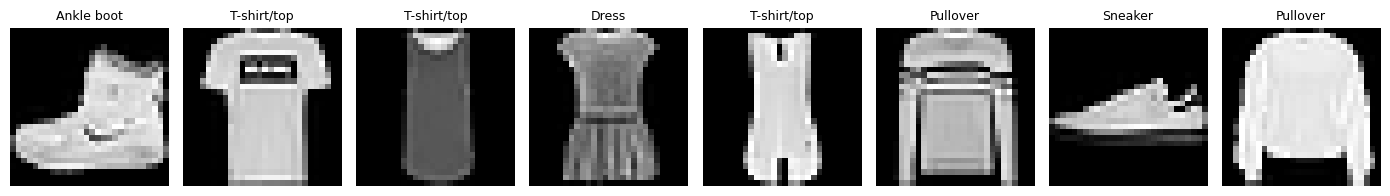

,class,count
0,T-shirt/top,6000
1,Trouser,6000
2,Pullover,6000
3,Dress,6000
4,Coat,6000
5,Sandal,6000
6,Shirt,6000
7,Sneaker,6000
8,Bag,6000
9,Ankle boot,6000


In [4]:

import gzip, zipfile, shutil
from torchvision import datasets, transforms

RAW_DIR = DATA_DIR / "fashionmnist_raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

def _prepare_fashion_mnist_from_zip(zip_path: Path, root: Path) -> bool:
    """Extracts the Fashion-MNIST .gz files from the official GitHub zip
    into torchvision's expected layout: <root>/FashionMNIST/raw/*.ubyte
    Returns True if raw files are present after the operation.
    """
    zip_path = Path(zip_path)
    if not zip_path.exists():
        return False

    extract_dir = root / "fashion-mnist-master_extracted"
    extract_dir.mkdir(parents=True, exist_ok=True)


    marker = extract_dir / ".extracted_ok"
    if not marker.exists():
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extractall(extract_dir)
        marker.write_text("ok")

    src_dir = extract_dir / "fashion-mnist-master" / "data" / "fashion"
    if not src_dir.exists():

        return False

    raw_dir = root / "FashionMNIST" / "raw"
    raw_dir.mkdir(parents=True, exist_ok=True)

    needed = [
        "train-images-idx3-ubyte",
        "train-labels-idx1-ubyte",
        "t10k-images-idx3-ubyte",
        "t10k-labels-idx1-ubyte",
    ]

    for fname in needed:
        out_path = raw_dir / fname
        if out_path.exists():
            continue
        gz_path = src_dir / (fname + ".gz")
        if not gz_path.exists():
            return False
        with gzip.open(gz_path, "rb") as f_in, open(out_path, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

    return all((raw_dir / f).exists() for f in needed)

raw_ready = False
if FASHION_ZIP_SRC is not None:
    raw_ready = _prepare_fashion_mnist_from_zip(FASHION_ZIP_SRC, RAW_DIR)

DOWNLOAD = not raw_ready
print("Fashion-MNIST raw ready:", raw_ready, "| download:", DOWNLOAD)

explore_tf = transforms.Compose([transforms.ToTensor()])

train_ds_raw = datasets.FashionMNIST(root=str(RAW_DIR), train=True, download=DOWNLOAD, transform=explore_tf)
test_ds_raw  = datasets.FashionMNIST(root=str(RAW_DIR), train=False, download=DOWNLOAD, transform=explore_tf)

class_names = train_ds_raw.classes
print("Classes:", class_names)
print("Train size:", len(train_ds_raw), "Test size:", len(test_ds_raw))


imgs = [train_ds_raw[i][0].squeeze().numpy() for i in range(8)]
labels = [class_names[int(train_ds_raw[i][1])] for i in range(8)]
show_image_grid(imgs, labels, n=8, figsize=(14,3))


y_train = np.array(train_ds_raw.targets, dtype=int)
counts = np.bincount(y_train, minlength=len(class_names))
df_counts = pd.DataFrame({"class": class_names, "count": counts})
display(df_counts)


In [5]:
from torchvision import transforms, datasets

IMG_SIZE = 224

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

train_ds = datasets.FashionMNIST(root=str(RAW_DIR), train=True, download=DOWNLOAD, transform=train_tf)
test_ds  = datasets.FashionMNIST(root=str(RAW_DIR), train=False, download=DOWNLOAD, transform=test_tf)


TRAIN_N = 15000
TEST_N  = 5000

rng = np.random.RandomState(SEED)
train_idx = rng.choice(len(train_ds), size=TRAIN_N, replace=False)
test_idx  = np.random.RandomState(SEED+1).choice(len(test_ds), size=TEST_N, replace=False)

train_sub = Subset(train_ds, train_idx)
test_sub  = Subset(test_ds, test_idx)

BATCH = 64 if DEVICE=="cuda" else 32

train_loader = DataLoader(train_sub, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=(DEVICE=="cuda"))
test_loader  = DataLoader(test_sub, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=(DEVICE=="cuda"))

print("Train subset:", len(train_sub), "Test subset:", len(test_sub), "Batch:", BATCH)


Train subset: 15000 Test subset: 5000 Batch: 64


In [6]:

from torchvision import models

num_classes = len(class_names)

vision_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
vision_model.fc = nn.Linear(vision_model.fc.in_features, num_classes)
vision_model = vision_model.to(DEVICE)

def set_backbone_trainable(model, trainable: bool):
    for name, p in model.named_parameters():
        if not name.startswith("fc."):
            p.requires_grad = trainable


set_backbone_trainable(vision_model, trainable=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, vision_model.parameters()),
                              lr=3e-4, weight_decay=1e-4)

print("Trainable params:", sum(p.numel() for p in vision_model.parameters() if p.requires_grad))


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


Trainable params: 5130


Epoch 1/2 | train loss 1.4684 acc 0.5735 | val loss 1.1146 acc 0.7062
Epoch 2/2 | train loss 0.3748 acc 0.8675 | val loss 0.2811 acc 0.9024


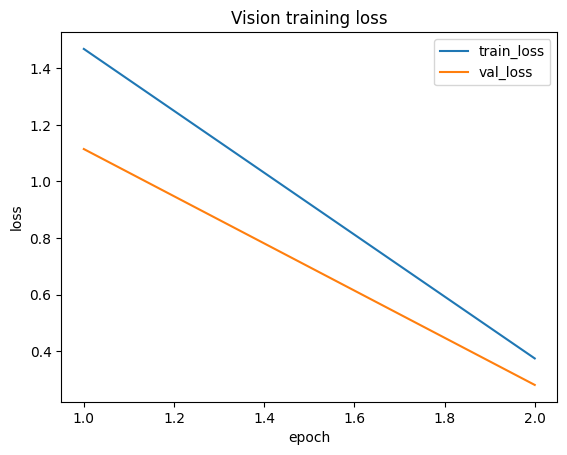

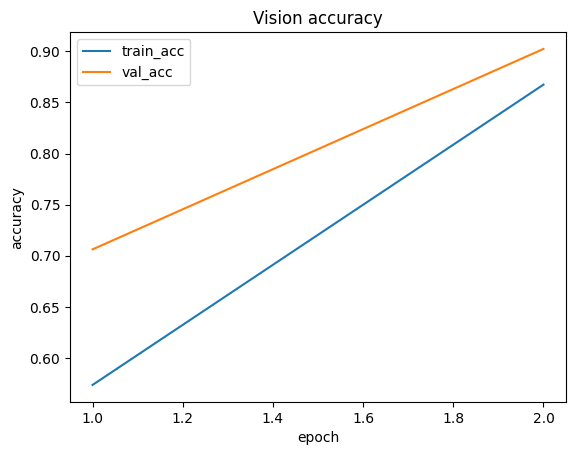

Saved: /content/mm_retail_bot/artifacts/vision_resnet18_fashionmnist.pt


In [7]:

from sklearn.metrics import accuracy_score
import torch

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    losses, y_true, y_pred = [], [], []
    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        y_true.extend(y.detach().cpu().numpy().tolist())
        y_pred.extend(logits.argmax(dim=1).detach().cpu().numpy().tolist())
    return float(np.mean(losses)), accuracy_score(y_true, y_pred)

@torch.no_grad()
def eval_model(model, loader, criterion):
    model.eval()
    losses, y_true, y_pred = [], [], []
    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        losses.append(loss.item())
        y_true.extend(y.detach().cpu().numpy().tolist())
        y_pred.extend(logits.argmax(dim=1).detach().cpu().numpy().tolist())
    return float(np.mean(losses)), accuracy_score(y_true, y_pred), np.array(y_true), np.array(y_pred)

history = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

EPOCHS = 2
for epoch in range(1, EPOCHS+1):
    if epoch == 2:
        set_backbone_trainable(vision_model, trainable=True)
        optimizer = torch.optim.AdamW(vision_model.parameters(), lr=1e-4, weight_decay=1e-4)

    tr_loss, tr_acc = train_one_epoch(vision_model, train_loader, optimizer, criterion)
    va_loss, va_acc, _, _ = eval_model(vision_model, test_loader, criterion)

    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    print(f"Epoch {epoch}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")

df_hist = pd.DataFrame(history)

plt.figure()
plt.plot(df_hist["epoch"], df_hist["train_loss"], label="train_loss")
plt.plot(df_hist["epoch"], df_hist["val_loss"], label="val_loss")
plt.legend(); plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Vision training loss")
plt.show()

plt.figure()
plt.plot(df_hist["epoch"], df_hist["train_acc"], label="train_acc")
plt.plot(df_hist["epoch"], df_hist["val_acc"], label="val_acc")
plt.legend(); plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Vision accuracy")
plt.show()

VISION_CKPT = ART_DIR / "vision_resnet18_fashionmnist.pt"
torch.save({"state_dict": vision_model.state_dict(), "class_names": class_names, "img_size": IMG_SIZE}, VISION_CKPT)
print("Saved:", VISION_CKPT)

Final vision val acc: 0.9024
              precision    recall  f1-score   support

 T-shirt/top     0.9298    0.8485    0.8873       515
     Trouser     0.9922    0.9770    0.9846       522
    Pullover     0.7893    0.9237    0.8512       511
       Dress     0.8702    0.9145    0.8918       491
        Coat     0.8992    0.6933    0.7829       489
      Sandal     0.9920    0.9688    0.9803       513
       Shirt     0.6853    0.7731    0.7266       476
     Sneaker     0.9440    0.9760    0.9598       501
         Bag     0.9896    0.9735    0.9815       490
  Ankle boot     0.9733    0.9634    0.9683       492

    accuracy                         0.9024      5000
   macro avg     0.9065    0.9012    0.9014      5000
weighted avg     0.9078    0.9024    0.9027      5000



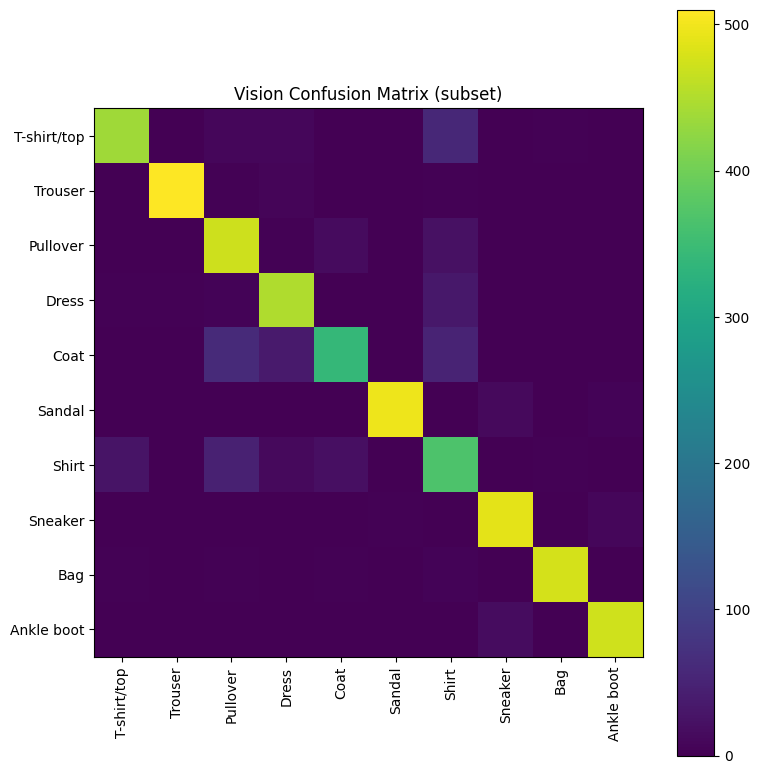

In [8]:

from sklearn.metrics import classification_report, confusion_matrix

val_loss, val_acc, y_true, y_pred = eval_model(vision_model, test_loader, criterion)
print("Final vision val acc:", val_acc)

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation="nearest")
plt.title("Vision Confusion Matrix (subset)")
plt.xticks(range(len(class_names)), class_names, rotation=90)
plt.yticks(range(len(class_names)), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Saved embeddings: /content/mm_retail_bot/artifacts/clip_embeddings.npy (4000, 512)
Saved meta: /content/mm_retail_bot/artifacts/clip_meta.json


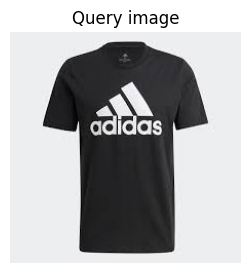

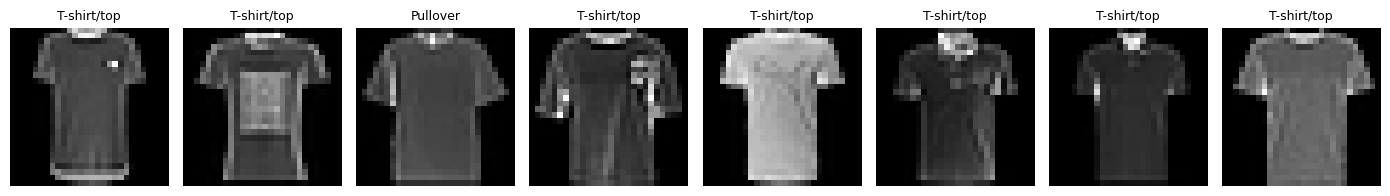

In [9]:

import logging, warnings
logging.getLogger("huggingface_hub").setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning, message=r".*HF_TOKEN.*")

import json
from PIL import Image
import torch
import torch.nn.functional as F
from transformers import CLIPModel, CLIPProcessor

clip_model_name = "openai/clip-vit-base-patch32"
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)
clip_model = CLIPModel.from_pretrained(clip_model_name).to(DEVICE).eval()

INDEX_N = 4000
rng = np.random.RandomState(SEED + 2)
index_idx = rng.choice(len(test_ds_raw), size=INDEX_N, replace=False)

INDEX_IMG_DIR = DATA_DIR / "index_images"
INDEX_IMG_DIR.mkdir(parents=True, exist_ok=True)

def get_pil_from_ds(ds_raw, i: int):
    x, y = ds_raw[i]  # tensor 1x28x28 in [0,1]
    arr = (x.squeeze().numpy() * 255).astype(np.uint8)

    pil = Image.fromarray(arr).convert("RGB")
    return pil, int(y)

@torch.no_grad()
def clip_image_embed(pil_images, batch=64):
    """Return unit-normalized CLIP image embeddings as a float32 NumPy array."""
    embs = []
    for i in range(0, len(pil_images), batch):
        chunk = pil_images[i:i+batch]
        inputs = clip_processor(images=chunk, return_tensors="pt")
        pixel_values = inputs["pixel_values"].to(DEVICE)


        vision_out = clip_model.vision_model(pixel_values=pixel_values)
        pooled = vision_out.pooler_output
        feats = clip_model.visual_projection(pooled)

        feats = F.normalize(feats, dim=-1)
        embs.append(feats.detach().cpu().numpy().astype("float32"))
    return np.vstack(embs)

paths, y_list, pil_list = [], [], []
for n, idx in enumerate(index_idx):
    pil, y = get_pil_from_ds(test_ds_raw, int(idx))
    out_path = INDEX_IMG_DIR / f"item_{n:05d}.png"
    if not out_path.exists():
        pil.save(out_path)
    paths.append(str(out_path))
    y_list.append(int(y))
    pil_list.append(pil)

emb = clip_image_embed(pil_list, batch=64)
CLIP_EMB_PATH = ART_DIR / "clip_embeddings.npy"
np.save(CLIP_EMB_PATH, emb)

meta = {
    "index_idx": index_idx.tolist(),
    "y_list": list(map(int, y_list)),
    "paths": paths,
    "class_names": class_names,
    "clip_model": clip_model_name
}
META_PATH = ART_DIR / "clip_meta.json"
META_PATH.write_text(json.dumps(meta, indent=2))

print("Saved embeddings:", CLIP_EMB_PATH, emb.shape)
print("Saved meta:", META_PATH)


q_img = Image.open(SAMPLE_IMAGE_PATH).convert("RGB")
q_emb = clip_image_embed([q_img], batch=1)  # (1, d)
sims = (emb @ q_emb.T).squeeze(1)
topk = sims.argsort()[::-1][:8]

plt.figure(figsize=(3,3))
plt.imshow(q_img); plt.axis("off"); plt.title("Query image")
plt.show()

recs = [Image.open(paths[i]).convert("RGB") for i in topk]
rec_labels = [class_names[y_list[i]] for i in topk]
show_image_grid([np.array(r) for r in recs], rec_labels, n=8, figsize=(14,3))


In [10]:
import whisper
from jiwer import wer

whisper_model_size = "tiny"
stt_model = whisper.load_model(whisper_model_size, device=DEVICE)

audio_path = str(SAMPLE_AUDIO_PATH)
print("Transcribing:", audio_path)

result = stt_model.transcribe(audio_path, fp16=(DEVICE=="cuda"))
transcript = result.get("text","").strip()
print("Transcript:", transcript)

GROUND_TRUTH = ""
if GROUND_TRUTH.strip():
    print("WER:", wer(GROUND_TRUTH.lower(), transcript.lower()))
else:
    print("WER skipped (no ground truth provided).")


100%|██████████████████████████████████████| 72.1M/72.1M [00:00<00:00, 115MiB/s]


Transcribing: /content/mm_retail_bot/data/sample_query_audio.mp3
Transcript: Show me something similar but in different size.
WER skipped (no ground truth provided).


MFCC raw shape: (40, 271) | fixed shape: (40, 300) | sr: 24000


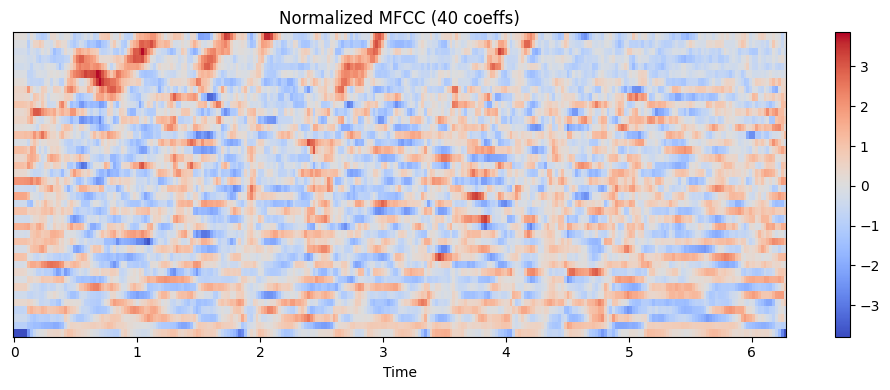

Augmented MFCC dataset shape: (9, 40, 300)


In [11]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

audio_path = str(SAMPLE_AUDIO_PATH)
y, sr = librosa.load(audio_path, sr=None)


n_mfcc = 40
n_fft = 1024
hop_length = 256

mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)


mfcc_mean = mfcc.mean(axis=1, keepdims=True)
mfcc_std = mfcc.std(axis=1, keepdims=True) + 1e-8
mfcc_norm = (mfcc - mfcc_mean) / mfcc_std


MAX_FRAMES = 300
def pad_or_trunc(m, max_frames=MAX_FRAMES):
    if m.shape[1] >= max_frames:
        return m[:, :max_frames]
    pad = max_frames - m.shape[1]
    return np.pad(m, ((0,0),(0,pad)), mode="constant")

mfcc_fixed = pad_or_trunc(mfcc_norm, MAX_FRAMES)
print("MFCC raw shape:", mfcc.shape, "| fixed shape:", mfcc_fixed.shape, "| sr:", sr)

plt.figure(figsize=(10,4))
librosa.display.specshow(mfcc_norm, x_axis="time")
plt.colorbar()
plt.title("Normalized MFCC (40 coeffs)")
plt.tight_layout()
plt.show()


AUG_DIR = DATA_DIR / "audio_augmented"
AUG_DIR.mkdir(parents=True, exist_ok=True)

aug_mfccs = []
for i, rate in enumerate([0.9, 1.0, 1.1]):
    y_stretch = librosa.effects.time_stretch(y, rate=rate)
    for j, steps in enumerate([-2, 0, 2]):
        y_aug = librosa.effects.pitch_shift(y_stretch, sr=sr, n_steps=steps)
        mf = librosa.feature.mfcc(y=y_aug, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        mf = (mf - mf.mean(axis=1, keepdims=True)) / (mf.std(axis=1, keepdims=True) + 1e-8)
        mf = pad_or_trunc(mf, MAX_FRAMES)
        aug_mfccs.append(mf.astype(np.float32))

aug_mfccs = np.stack(aug_mfccs, axis=0)
print("Augmented MFCC dataset shape:", aug_mfccs.shape)


In [12]:
import re

INTENTS = ["find_similar","filter_color","filter_price","ask_size","ask_material","greeting","goodbye"]

TEMPLATES = {
    "find_similar": ["show me similar items","find something like this","recommend alternatives","similar products please","more like this"],
    "filter_color": ["in black","in white","in red","in blue","in green","show me {color} ones","i want it in {color}"],
    "filter_price": ["cheaper options","something cheaper","under 20 euros","premium version","budget friendly","less expensive"],
    "ask_size": ["do you have size m","size chart","what sizes are available","i need a large","is there a small size"],
    "ask_material": ["what material is it","is it cotton","is it leather","tell me the fabric","is it waterproof"],
    "greeting": ["hi","hello","hey","good morning","good evening"],
    "goodbye": ["bye","thanks bye","see you","goodbye","that is all"],
}

COLORS = ["black","white","red","blue","green","beige","brown"]

def normalize_text(t: str) -> str:
    t = t.lower().strip()
    t = re.sub(r"[^a-z0-9\s€$]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def build_intent_dataset(n_per_intent=120, seed=SEED):
    rng = random.Random(seed)
    texts, labels = [], []
    for intent in INTENTS:
        base = TEMPLATES[intent]
        for _ in range(n_per_intent):
            t = rng.choice(base)
            if "{color}" in t:
                t = t.format(color=rng.choice(COLORS))
            texts.append(normalize_text(t))
            labels.append(intent)
    df = pd.DataFrame({"text": texts, "intent": labels})
    df = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return df

df_intent = build_intent_dataset(n_per_intent=120)
print(df_intent.head())
print("Dataset size:", len(df_intent))
print(df_intent["intent"].value_counts())


                      text        intent
0                       hi      greeting
1              that is all       goodbye
2   recommend alternatives  find_similar
3       tell me the fabric  ask_material
4  similar products please  find_similar
Dataset size: 840
intent
greeting        120
goodbye         120
find_similar    120
ask_material    120
filter_price    120
ask_size        120
filter_color    120
Name: count, dtype: int64


In [13]:

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate as hf_evaluate

label2id = {lab:i for i,lab in enumerate(INTENTS)}
id2label = {i:lab for lab,i in label2id.items()}

df_intent["label"] = df_intent["intent"].map(label2id)
ds = Dataset.from_pandas(df_intent[["text","label"]])
ds = ds.train_test_split(test_size=0.2, seed=SEED)

tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tok_fn(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=32)

train_tok = ds["train"].map(tok_fn, batched=True)
val_tok   = ds["test"].map(tok_fn, batched=True)

model_intent = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(INTENTS),
    id2label=id2label,
    label2id=label2id
).to(DEVICE)

metric_acc = hf_evaluate.load("accuracy")
metric_f1  = hf_evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }


import transformers
print('Transformers version:', transformers.__version__)
args = TrainingArguments(
    output_dir=str(ART_DIR / "intent_model"),
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    report_to=[],
    fp16=(DEVICE=="cuda")
)

import inspect

trainer_kwargs = dict(
    model=model_intent,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    compute_metrics=compute_metrics
)


sig = inspect.signature(Trainer.__init__)
if "tokenizer" in sig.parameters:
    trainer = Trainer(**trainer_kwargs, tokenizer=tok)
elif "processing_class" in sig.parameters:
    trainer = Trainer(**trainer_kwargs, processing_class=tok)
else:
    trainer = Trainer(**trainer_kwargs)

trainer.train()
print(trainer.evaluate())

trainer.save_model(str(ART_DIR / "intent_distilbert"))
tok.save_pretrained(str(ART_DIR / "intent_distilbert"))
print("Saved intent model to:", ART_DIR / "intent_distilbert")


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Transformers version: 5.1.0


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.471784,0.750000,0.721882
2,No log,1.228966,0.904762,0.907965


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.2289661169052124, 'eval_accuracy': 0.9047619047619048, 'eval_f1_macro': 0.9079648803151109, 'eval_runtime': 0.0875, 'eval_samples_per_second': 1919.051, 'eval_steps_per_second': 34.269, 'epoch': 2.0}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Saved intent model to: /content/mm_retail_bot/artifacts/intent_distilbert


In [14]:

from transformers import AutoModel


vision_backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
vision_backbone.fc = nn.Identity()
vision_backbone = vision_backbone.to(DEVICE).eval()


text_backbone = AutoModel.from_pretrained(str(ART_DIR / "intent_distilbert")).to(DEVICE).eval()

@torch.no_grad()
def vision_embed(batch_imgs):
    feats = vision_backbone(batch_imgs.to(DEVICE))
    feats = feats / feats.norm(dim=-1, keepdim=True)
    return feats

@torch.no_grad()
def text_embed(texts):
    inputs = tok(texts, return_tensors="pt", truncation=True, padding=True, max_length=32).to(DEVICE)
    out = text_backbone(**inputs)
    cls = out.last_hidden_state[:, 0, :]
    cls = cls / cls.norm(dim=-1, keepdim=True)
    return cls

PAIR_N = 5000
pair_idx = np.random.RandomState(SEED+3).choice(len(train_ds), size=PAIR_N, replace=False)

rng = random.Random(SEED+4)
pair_texts, pair_labels = [], []
for i in pair_idx:
    intent = rng.choice(INTENTS)
    t = rng.choice(TEMPLATES[intent])
    if "{color}" in t:
        t = t.format(color=rng.choice(COLORS))
    pair_texts.append(normalize_text(t))
    _, y = train_ds_raw[int(i)]
    pair_labels.append(int(y))


tmp_imgs = torch.stack([train_ds[int(i)][0] for i in pair_idx[:128]])
v_dim = vision_embed(tmp_imgs).shape[1]
t_dim = text_embed(pair_texts[:16]).shape[1]
print("Vision emb dim:", v_dim, "| Text emb dim:", t_dim)

class FusionMLP(nn.Module):
    def __init__(self, v_dim, t_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(v_dim + t_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    def forward(self, v, t):
        return self.net(torch.cat([v, t], dim=1))

fusion_model = FusionMLP(v_dim, t_dim, len(class_names)).to(DEVICE)
opt = torch.optim.AdamW(fusion_model.parameters(), lr=2e-4, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

perm = np.random.RandomState(SEED+5).permutation(PAIR_N)
split = int(PAIR_N * 0.8)
tr_ids = perm[:split]
va_ids = perm[split:]

def fusion_epoch(idxs, train=True, batch=64):
    fusion_model.train(train)
    losses, yt, yp = [], [], []
    for start in range(0, len(idxs), batch):
        b_ids = idxs[start:start+batch]
        x_batch = torch.stack([train_ds[int(pair_idx[i])][0] for i in b_ids])
        y_batch = torch.tensor([pair_labels[i] for i in b_ids], dtype=torch.long)
        txt_batch = [pair_texts[i] for i in b_ids]

        with torch.no_grad():
            v = vision_embed(x_batch)
            t = text_embed(txt_batch)

        logits = fusion_model(v, t)
        loss = loss_fn(logits, y_batch.to(DEVICE))

        if train:
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

        losses.append(loss.item())
        yt.extend(y_batch.numpy().tolist())
        yp.extend(logits.argmax(dim=1).detach().cpu().numpy().tolist())
    return float(np.mean(losses)), accuracy_score(yt, yp)

for ep in range(1, 3):
    tr_loss, tr_acc = fusion_epoch(tr_ids, train=True, batch=64)
    va_loss, va_acc = fusion_epoch(va_ids, train=False, batch=64)
    print(f"Fusion epoch {ep}/2 | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")

FUSION_CKPT = ART_DIR / "fusion_mlp.pt"
torch.save({"state_dict": fusion_model.state_dict(), "v_dim": v_dim, "t_dim": t_dim, "class_names": class_names}, FUSION_CKPT)
print("Saved fusion model:", FUSION_CKPT)


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: /content/mm_retail_bot/artifacts/intent_distilbert
Key                   | Status     |  | 
----------------------+------------+--+-
pre_classifier.weight | UNEXPECTED |  | 
pre_classifier.bias   | UNEXPECTED |  | 
classifier.weight     | UNEXPECTED |  | 
classifier.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Vision emb dim: 512 | Text emb dim: 768
Fusion epoch 1/2 | train loss 2.2632 acc 0.2938 | val loss 2.1622 acc 0.4020
Fusion epoch 2/2 | train loss 1.8545 acc 0.4625 | val loss 1.4925 acc 0.5980
Saved fusion model: /content/mm_retail_bot/artifacts/fusion_mlp.pt


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

User text: Show me something similar but in different size.
Predicted intent: find_similar (conf=0.198)
Predicted category: T-shirt/top (conf=0.655)


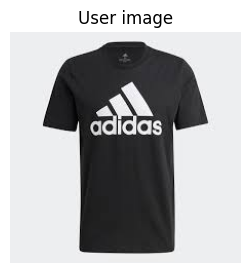

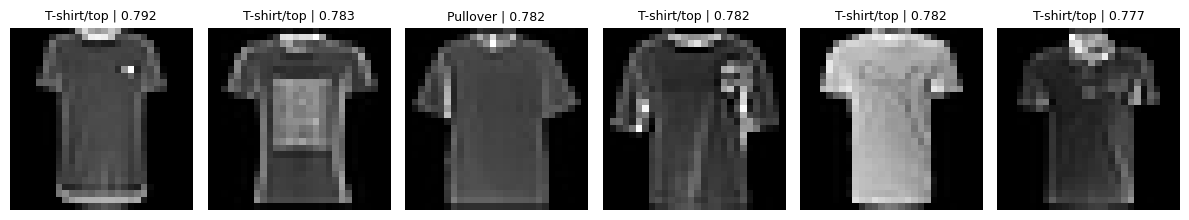

In [15]:

import json
from PIL import Image
from torchvision import transforms
from transformers import CLIPModel, CLIPProcessor, AutoTokenizer, AutoModelForSequenceClassification


ckpt = torch.load(VISION_CKPT, map_location="cpu")
vision_infer = models.resnet18(weights=None)
vision_infer.fc = nn.Linear(vision_infer.fc.in_features, len(ckpt["class_names"]))
vision_infer.load_state_dict(ckpt["state_dict"])
vision_infer = vision_infer.to(DEVICE).eval()
infer_classes = ckpt["class_names"]

infer_tf = transforms.Compose([
    transforms.Resize((ckpt["img_size"], ckpt["img_size"])),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

@torch.no_grad()
def predict_category(image_path: str):
    pil = Image.open(image_path).convert("RGB")
    x = infer_tf(pil).unsqueeze(0).to(DEVICE)
    logits = vision_infer(x)
    prob = torch.softmax(logits, dim=1).squeeze(0).detach().cpu().numpy()
    top = int(prob.argmax())
    return infer_classes[top], float(prob[top])


clip_model_name = "openai/clip-vit-base-patch32"
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)
clip_model = CLIPModel.from_pretrained(clip_model_name).to(DEVICE).eval()

CLIP_EMB_PATH = ART_DIR / "clip_embeddings.npy"
META_PATH = ART_DIR / "clip_meta.json"

emb = np.load(CLIP_EMB_PATH).astype("float32")
meta = json.loads(META_PATH.read_text())
paths = meta["paths"]
y_list = meta["y_list"]
class_names_local = meta["class_names"]

@torch.no_grad()
def clip_embed_image(pil: Image.Image):
    """Return a (1, d) unit-normalized CLIP image embedding.

    NOTE: In some Transformers versions, `get_image_features` returns a ModelOutput
    (e.g., BaseModelOutputWithPooling). This function handles both Tensor and ModelOutput.
    """
    inp = clip_processor(images=[pil], return_tensors="pt").to(DEVICE)
    out = clip_model.get_image_features(**inp)


    if not isinstance(out, torch.Tensor):
        if hasattr(out, "image_embeds") and isinstance(out.image_embeds, torch.Tensor):
            out = out.image_embeds
        elif hasattr(out, "pooler_output") and isinstance(out.pooler_output, torch.Tensor):
            out = out.pooler_output
        else:
            raise TypeError(f"Unexpected CLIP image features type: {type(out)}")

    denom = out.norm(dim=-1, keepdim=True).clamp(min=1e-12)
    out = out / denom
    return out.detach().cpu().numpy().astype("float32")  # (1, d)

def recommend_similar(image_path: str, k: int = 6):
    q_img = Image.open(image_path).convert("RGB")
    q = clip_embed_image(q_img)                      # (1,d)
    sims = (emb @ q.T).squeeze(1)                    # (N,)
    topk = sims.argsort()[::-1][:k]
    rec_imgs, rec_labels, rec_scores = [], [], []
    for i in topk:
        i = int(i)
        rec_scores.append(float(sims[i]))
        rec_imgs.append(Image.open(paths[i]).convert("RGB") if os.path.exists(paths[i]) else q_img)
        rec_labels.append(class_names_local[int(y_list[i])] if 0 <= int(y_list[i]) < len(class_names_local) else "")
    return rec_imgs, rec_labels, rec_scores


intent_dir = ART_DIR / "intent_distilbert"
tok = AutoTokenizer.from_pretrained(str(intent_dir))
intent_model = AutoModelForSequenceClassification.from_pretrained(str(intent_dir)).to(DEVICE).eval()
id2label = intent_model.config.id2label

@torch.no_grad()
def predict_intent(text: str):
    text = (text or "").strip()
    if not text:
        return ("", 0.0)
    inputs = tok(text, return_tensors="pt", truncation=True, padding=True, max_length=32).to(DEVICE)
    logits = intent_model(**inputs).logits
    probs = torch.softmax(logits, dim=1).squeeze(0).detach().cpu().numpy()
    idx = int(probs.argmax())
    label = id2label.get(str(idx), id2label.get(idx, str(idx)))
    return label, float(probs[idx])


img_path = str(SAMPLE_IMAGE_PATH)
user_text = transcript if "transcript" in globals() else ""

intent, intent_conf = predict_intent(user_text.lower())
cat, cat_conf = predict_category(img_path)
recs, rec_labels, sim_scores = recommend_similar(img_path, k=6)

print("User text:", user_text)
print("Predicted intent:", intent, f"(conf={intent_conf:.3f})")
print("Predicted category:", cat, f"(conf={cat_conf:.3f})")

plt.figure(figsize=(3,3))
plt.imshow(Image.open(img_path).convert("RGB"))
plt.axis("off")
plt.title("User image")
plt.show()


show_image_grid([np.array(r) for r in recs], [f"{lab} | {s:.3f}" for lab, s in zip(rec_labels, sim_scores)], n=6, figsize=(12,3))


In [16]:
app_py = UI_DIR / "app.py"
requirements_txt = UI_DIR / "requirements.txt"
dockerfile = UI_DIR / "Dockerfile"

app_code = r'''
import os, json, shutil, tempfile
from pathlib import Path

import numpy as np
import streamlit as st
from PIL import Image

import torch
from torch import nn
from torchvision import models, transforms

from transformers import CLIPModel, CLIPProcessor, AutoTokenizer, AutoModelForSequenceClassification

# Optional Whisper (audio → text). App still runs fine without it.
try:
    import whisper
    WHISPER_OK = True
except Exception:
    WHISPER_OK = False

# -----------------------------
# Paths (relative, works locally)
# -----------------------------
BASE_DIR = Path(__file__).resolve().parent          # .../ui
PROJECT_DIR = BASE_DIR.parent                       # .../mm_retail_bot
DATA_DIR = PROJECT_DIR / "data"
ART_DIR  = PROJECT_DIR / "artifacts"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# Load artifacts with caching
# -----------------------------
@st.cache_resource
def load_vision():
    ckpt_path = ART_DIR / "vision_resnet18_fashionmnist.pt"
    if not ckpt_path.exists():
        raise FileNotFoundError(f"Missing vision checkpoint: {ckpt_path}")

    ckpt = torch.load(str(ckpt_path), map_location="cpu")
    class_names = ckpt["class_names"]
    img_size = ckpt["img_size"]

    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, len(class_names))
    model.load_state_dict(ckpt["state_dict"])
    model = model.to(DEVICE).eval()

    infer_tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ])
    return model, infer_tf, class_names

@st.cache_resource
def load_clip():
    clip_name = "openai/clip-vit-base-patch32"
    processor = CLIPProcessor.from_pretrained(clip_name)
    model = CLIPModel.from_pretrained(clip_name).to(DEVICE).eval()
    return processor, model

@st.cache_resource
def load_gallery():
    emb_path = ART_DIR / "clip_embeddings.npy"
    meta_path = ART_DIR / "clip_meta.json"
    if not emb_path.exists() or not meta_path.exists():
        raise FileNotFoundError("Missing gallery artifacts. Run the notebook cells to build CLIP embeddings first.")
    emb = np.load(emb_path).astype("float32")  # (N,d), unit-normalized
    meta = json.loads(meta_path.read_text())
    return emb, meta

@st.cache_resource
def load_intent():
    model_dir = ART_DIR / "intent_distilbert"
    if not model_dir.exists():
        raise FileNotFoundError(f"Missing intent model folder: {model_dir}")
    tok = AutoTokenizer.from_pretrained(str(model_dir))
    model = AutoModelForSequenceClassification.from_pretrained(str(model_dir)).to(DEVICE).eval()
    id2label = model.config.id2label
    return tok, model, id2label

@st.cache_resource
def load_whisper():
    if not WHISPER_OK:
        return None
    # tiny is small + fast enough for demo
    return whisper.load_model("tiny", device=DEVICE)

# -----------------------------
# Inference helpers
# -----------------------------
@torch.no_grad()
def predict_category(pil: Image.Image):
    vision, infer_tf, class_names = load_vision()
    x = infer_tf(pil).unsqueeze(0).to(DEVICE)
    logits = vision(x)
    prob = torch.softmax(logits, dim=1).squeeze(0).detach().cpu().numpy()
    top = int(prob.argmax())
    return class_names[top], float(prob[top])

@torch.no_grad()
def clip_embed(pil: Image.Image):
    processor, model = load_clip()
    inp = processor(images=[pil], return_tensors="pt").to(DEVICE)
    feat = model.get_image_features(**inp)
    feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.detach().cpu().numpy().astype("float32")  # (1,d)

@torch.no_grad()
def predict_intent(text: str):
    tok, model, id2label = load_intent()
    text = (text or "").strip()
    if not text:
        return ("", 0.0)
    inputs = tok(text, return_tensors="pt", truncation=True, padding=True, max_length=32).to(DEVICE)
    logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=1).squeeze(0).detach().cpu().numpy()
    idx = int(probs.argmax())
    label = id2label.get(str(idx), id2label.get(idx, str(idx)))
    return label, float(probs[idx])

def retrieve_similar(pil: Image.Image, k: int = 6):
    emb, meta = load_gallery()
    q = clip_embed(pil)               # (1,d)
    sims = (emb @ q.T).squeeze(1)     # (N,)
    topk = sims.argsort()[::-1][:k]
    results = []
    for i in topk:
        i = int(i)
        path = meta["paths"][i] if i < len(meta.get("paths", [])) else None
        y = int(meta["y_list"][i]) if i < len(meta.get("y_list", [])) else -1
        label = meta["class_names"][y] if (0 <= y < len(meta.get("class_names", []))) else ""
        results.append((path, label, float(sims[i])))
    return results

def transcribe_audio(audio_bytes: bytes, suffix: str = ".mp3") -> str:
    stt = load_whisper()
    if stt is None:
        raise RuntimeError("Whisper is not installed. Install 'openai-whisper' and ensure ffmpeg is on PATH.")
    with tempfile.NamedTemporaryFile(delete=False, suffix=suffix) as tmp:
        tmp.write(audio_bytes)
        tmp_path = tmp.name
    try:
        out = stt.transcribe(tmp_path, fp16=(DEVICE=="cuda"))
        return (out.get("text") or "").strip()
    finally:
        try:
            os.remove(tmp_path)
        except Exception:
            pass

# -----------------------------
# Streamlit UI
# -----------------------------
st.set_page_config(page_title="Multi-Modal Retail Bot", layout="wide")
st.title("🛍️ Multi‑Modal Retail Product Discovery Bot (Localhost Demo)")

# Pre-flight checks with friendly UI errors (no stack-trace spam)
try:
    _ = load_vision()
    _ = load_gallery()
    _ = load_intent()
except Exception as e:
    st.error(f"App is missing artifacts: {e}")
    st.info("Run the notebook end-to-end once to generate artifacts (vision checkpoint, CLIP gallery, intent model).")
    st.stop()

left, right = st.columns(2, gap="large")

with left:
    st.subheader("1) Product image")
    use_sample = st.checkbox("Use the included sample product image", value=False)
    pil = None

    if use_sample:
        sample_path = DATA_DIR / "sample_product_image.jpg"
        if sample_path.exists():
            pil = Image.open(sample_path).convert("RGB")
            st.image(pil, caption="Sample product image", use_container_width=True)
        else:
            st.warning("Sample image missing in data/. Upload one instead.")

    uploaded_img = st.file_uploader("Upload an image (jpg/png)", type=["jpg", "jpeg", "png"])
    if uploaded_img is not None:
        pil = Image.open(uploaded_img).convert("RGB")
        st.image(pil, caption="Uploaded image", use_container_width=True)

with right:
    st.subheader("2) Query (text or voice)")
    user_text = st.text_input("Type your query (e.g., 'find similar sneakers')", value="")

    use_sample_audio = st.checkbox("Use the included sample query audio", value=False)
    if use_sample_audio:
        sample_audio = DATA_DIR / "sample_query_audio.mp3"
        if sample_audio.exists():
            st.audio(str(sample_audio))
            if st.button("Transcribe sample audio"):
                try:
                    user_text = transcribe_audio(sample_audio.read_bytes(), suffix=sample_audio.suffix)
                    st.success("Transcribed!")
                    st.write("Transcript:", user_text)
                except Exception as e:
                    st.warning(str(e))
        else:
            st.warning("Sample audio missing in data/.")

    audio_file = st.file_uploader("Or upload an audio query (mp3/wav/m4a)", type=["mp3", "wav", "m4a"])
    if audio_file is not None:
        st.audio(audio_file)
        if st.button("Transcribe uploaded audio"):
            try:
                user_text = transcribe_audio(audio_file.read(), suffix=Path(audio_file.name).suffix or ".mp3")
                st.success("Transcribed!")
                st.write("Transcript:", user_text)
            except Exception as e:
                st.warning(str(e))

st.divider()

if pil is None:
    st.info("Upload (or select) a product image to get predictions and recommendations.")
    st.stop()

cat, cat_conf = predict_category(pil)
intent, intent_conf = predict_intent(user_text.lower())

st.subheader("Predictions")
st.write({
    "category": cat,
    "category_conf": round(cat_conf, 3),
    "intent": intent,
    "intent_conf": round(intent_conf, 3),
    "query_text": user_text
})

st.subheader("Similar products")
recs = retrieve_similar(pil, k=6)
cols = st.columns(6)

for col, (path, label, score) in zip(cols, recs):
    if path and os.path.exists(path):
        col.image(Image.open(path).convert("RGB"), caption=f"{label}\nsim={score:.3f}", width=140)
    else:
        col.write(f"{label}\nsim={score:.3f}")
'''


UI_DIR.mkdir(parents=True, exist_ok=True)
app_py.write_text(app_code, encoding="utf-8")

requirements_txt.write_text("""streamlit>=1.33.0
numpy>=1.24
pandas>=2.0
Pillow>=10.0.0
torch
torchvision
transformers>=4.41.0
openai-whisper>=20231117
librosa>=0.10.2
soundfile>=0.12.1
""", encoding="utf-8")

dockerfile.write_text("""FROM python:3.11-slim
WORKDIR /app
RUN apt-get update && apt-get install -y ffmpeg && rm -rf /var/lib/apt/lists/*
COPY . /app
RUN pip install --no-cache-dir -r requirements.txt
EXPOSE 8501
CMD [\"streamlit\", \"run\", \"app.py\", \"--server.port=8501\", \"--server.address=0.0.0.0\"]
""", encoding="utf-8")

print("✅ Streamlit app written to:", app_py)
print("✅ requirements.txt written to:", requirements_txt)
print("✅ Dockerfile written to:", dockerfile)


import py_compile
py_compile.compile(str(app_py), doraise=True)
print("✅ app.py syntax check passed.")

print("\nTo run locally:")
print(f"  cd {UI_DIR}")
print("  pip install -r requirements.txt")
print("  streamlit run app.py")


✅ Streamlit app written to: /content/mm_retail_bot/ui/app.py
✅ requirements.txt written to: /content/mm_retail_bot/ui/requirements.txt
✅ Dockerfile written to: /content/mm_retail_bot/ui/Dockerfile
✅ app.py syntax check passed.

To run locally:
  cd /content/mm_retail_bot/ui
  pip install -r requirements.txt
  streamlit run app.py


In [17]:
from pathlib import Path
import py_compile

app_path = UI_DIR / "app.py"
req_path = UI_DIR / "requirements.txt"

print("Streamlit app:", app_path)
print("Requirements:", req_path)


needed = [
    ART_DIR / "vision_resnet18_fashionmnist.pt",
    ART_DIR / "clip_embeddings.npy",
    ART_DIR / "clip_meta.json",
    ART_DIR / "intent_distilbert",
]
missing = [p for p in needed if not p.exists()]
if missing:
    raise FileNotFoundError("Missing artifacts:\n- " + "\n- ".join(str(p) for p in missing))

print("✅ All required artifacts exist.")


py_compile.compile(str(app_path), doraise=True)
print("✅ app.py syntax check passed (py_compile).")

print("\nHow to run on localhost (recommended):\n")
print("1) Download the project zip from the last cell (CELL 17).")
print("2) Unzip it, then in a terminal:")
print("   cd mm_retail_bot/ui")
print("   python -m pip install -r requirements.txt")
print("   streamlit run app.py")
print("\nOpen: http://localhost:8501")


Streamlit app: /content/mm_retail_bot/ui/app.py
Requirements: /content/mm_retail_bot/ui/requirements.txt
✅ All required artifacts exist.
✅ app.py syntax check passed (py_compile).

How to run on localhost (recommended):

1) Download the project zip from the last cell (CELL 17).
2) Unzip it, then in a terminal:
   cd mm_retail_bot/ui
   python -m pip install -r requirements.txt
   streamlit run app.py

Open: http://localhost:8501


In [18]:

from pathlib import Path
import textwrap, shutil

APP_PATH = Path("/content/mm_retail_bot/ui/app.py")
assert APP_PATH.exists(), f"Missing: {APP_PATH}"


bak = APP_PATH.with_suffix(".py.bak")
shutil.copy2(APP_PATH, bak)
print("Backed up old app to:", bak)

APP_PATH.write_text(textwrap.dedent(r"""
import os, json
from pathlib import Path

import numpy as np
import streamlit as st
from PIL import Image

import torch

# ----------------------------
# Paths
# ----------------------------
BASE_DIR = Path(__file__).resolve().parents[1]          # mm_retail_bot/
ART_DIR  = BASE_DIR / "artifacts"
DATA_DIR = BASE_DIR / "data"
IDX_IMG_DIR = DATA_DIR / "index_images"

CLIP_EMB_PATH  = ART_DIR / "clip_embeddings.npy"
CLIP_META_PATH = ART_DIR / "clip_meta.json"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

st.set_page_config(page_title="Multimodal Retail Chatbot", layout="wide")
st.title("🛍️ Multimodal Retail Chatbot (Colab/Local)")

# ----------------------------
# Utilities
# ----------------------------
def safe_load_meta():
    if not CLIP_META_PATH.exists():
        return None
    with open(CLIP_META_PATH, "r", encoding="utf-8") as f:
        return json.load(f)

@st.cache_resource(show_spinner=False)
def load_clip():
    from transformers import CLIPModel, CLIPProcessor
    model_id = "openai/clip-vit-base-patch32"
    proc = CLIPProcessor.from_pretrained(model_id)
    model = CLIPModel.from_pretrained(model_id).to(DEVICE)
    model.eval()
    return model, proc

@torch.no_grad()
def clip_embed_pil(pil: Image.Image) -> np.ndarray:
    model, proc = load_clip()
    inputs = proc(images=[pil], return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(DEVICE)

    # Most stable across Transformers versions: forward(pixel_values=...) => output.image_embeds
    out = model(pixel_values=pixel_values)
    emb = out.image_embeds  # torch.Tensor (1, d)

    emb = emb / emb.norm(dim=-1, keepdim=True)
    return emb.detach().cpu().numpy().astype("float32")  # (1, d)

@st.cache_resource(show_spinner=False)
def load_index():
    if (not CLIP_EMB_PATH.exists()) or (not CLIP_META_PATH.exists()):
        return None, None
    emb = np.load(CLIP_EMB_PATH)  # (N, d)
    meta = safe_load_meta()
    return emb, meta

def recommend_similar(pil: Image.Image, k=6):
    emb, meta = load_index()
    if emb is None or meta is None:
        return [], []

    q = clip_embed_pil(pil)                 # (1, d)
    sims = (emb @ q.T).squeeze(1)           # (N,)
    topk = np.argsort(-sims)[:k].tolist()

    results = []
    for i in topk:
        item = meta[i] if isinstance(meta, list) else meta[str(i)]
        # Expect a stored filename or path
        fn = item.get("file") or item.get("filename") or item.get("path") or ""
        p = (IDX_IMG_DIR / fn) if fn else None
        results.append({"meta": item, "path": str(p) if p and p.exists() else None, "score": float(sims[i])})
    return results, topk

# ----------------------------
# UI
# ----------------------------
left, right = st.columns([1, 1], gap="large")

with left:
    st.subheader("1) Upload a product image")
    up = st.file_uploader("Image (jpg/png/webp)", type=["jpg", "jpeg", "png", "webp"])
    pil = Image.open(up).convert("RGB") if up else None
    if pil:
        st.image(pil, caption="Query image", use_container_width=True)

    st.subheader("2) Optional text query")
    user_text = st.text_input("What are you looking for?", value="black adidas t-shirt")

    run = st.button("🔎 Run search", type="primary", disabled=(pil is None))

with right:
    st.subheader("Recommendations")
    if not CLIP_EMB_PATH.exists() or not CLIP_META_PATH.exists():
        st.warning("Missing index artifacts. Re-run the notebook cells that generate:\n"
                   "- artifacts/clip_embeddings.npy\n- artifacts/clip_meta.json\n- data/index_images/*")
        st.stop()

    if run:
        with st.status("Loading models + searching… (first run may take time)", expanded=True) as status:
            try:
                recs, _ = recommend_similar(pil, k=6)
                status.update(label="Done ✅", state="complete")
            except Exception as e:
                status.update(label="Failed ❌", state="error")
                st.exception(e)
                st.stop()

        if not recs:
            st.info("No recommendations found.")
        else:
            cols = st.columns(3)
            for idx, r in enumerate(recs):
                c = cols[idx % 3]
                title = r["meta"].get("label") or r["meta"].get("class") or r["meta"].get("name") or f"Item {idx+1}"
                score = r["score"]
                with c:
                    st.caption(f"{title}  •  sim={score:.3f}")
                    if r["path"]:
                        st.image(r["path"], use_container_width=True)
                    else:
                        st.write("No preview image found on disk.")
""").strip() + "\n", encoding="utf-8")

print("✅ Patched app.py for fast boot + lazy loading.")
print("App path:", APP_PATH)

Backed up old app to: /content/mm_retail_bot/ui/app.py.bak
✅ Patched app.py for fast boot + lazy loading.
App path: /content/mm_retail_bot/ui/app.py


In [19]:

import os, time, re, subprocess, urllib.request
from pathlib import Path

APP_DIR = Path("/content/mm_retail_bot/ui")
APP_PATH = APP_DIR / "app.py"
assert APP_PATH.exists(), f"Missing {APP_PATH}"


subprocess.run(
    ["python", "-m", "pip", "install", "-q", "streamlit"],
    check=True
)


CLOUDFLARED = Path("/content/cloudflared")
if not CLOUDFLARED.exists():
    subprocess.run(
        ["wget", "-q", "-O", str(CLOUDFLARED),
         "https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64"],
        check=True
    )
    subprocess.run(["chmod", "+x", str(CLOUDFLARED)], check=True)


subprocess.run("pkill -f streamlit || true", shell=True)
subprocess.run("pkill -f cloudflared || true", shell=True)

STREAMLIT_LOG = "/content/streamlit.log"
TUNNEL_LOG = "/content/cloudflared.log"


with open(STREAMLIT_LOG, "w") as f:
    subprocess.Popen(
        [
            "python", "-m", "streamlit", "run", "app.py",
            "--server.port=8501",
            "--server.address=0.0.0.0",
            "--server.headless=true",
            "--server.enableCORS=false",
            "--server.enableXsrfProtection=false",
            "--browser.gatherUsageStats=false",
        ],
        cwd=str(APP_DIR),
        stdout=f,
        stderr=subprocess.STDOUT
    )

print("⏳ Waiting for Streamlit to start...")


ready = False
for i in range(60):
    try:
        urllib.request.urlopen("http://127.0.0.1:8501", timeout=1)
        ready = True
        break
    except Exception:
        time.sleep(1)

if not ready:
    print("❌ Streamlit failed to start.")
    print("\nLast 40 lines of log:\n")
    subprocess.run(["tail", "-n", "40", STREAMLIT_LOG])
    raise SystemExit

print("✅ Streamlit is running.")


with open(TUNNEL_LOG, "w") as f:
    subprocess.Popen(
        [str(CLOUDFLARED), "tunnel", "--url", "http://127.0.0.1:8501", "--no-autoupdate"],
        stdout=f,
        stderr=subprocess.STDOUT
    )

print("⏳ Waiting for public URL...")


public_url = None
for _ in range(60):
    if os.path.exists(TUNNEL_LOG):
        txt = open(TUNNEL_LOG, "r", errors="ignore").read()
        m = re.search(r"https://[^\s]+trycloudflare\.com", txt)
        if m:
            public_url = m.group(0)
            break
    time.sleep(1)

print("\n📄 Streamlit log:", STREAMLIT_LOG)
print("📄 Tunnel log:", TUNNEL_LOG)

if public_url:
    print("\n🚀 OPEN THIS URL:\n", public_url)
else:
    print("\n❌ Tunnel failed. Last log lines:\n")
    subprocess.run(["tail", "-n", "40", TUNNEL_LOG])

⏳ Waiting for Streamlit to start...
✅ Streamlit is running.
⏳ Waiting for public URL...

📄 Streamlit log: /content/streamlit.log
📄 Tunnel log: /content/cloudflared.log

🚀 OPEN THIS URL:
 https://liable-chicken-delivered-abu.trycloudflare.com


In [20]:

import shutil

bundle_path = PROJECT_DIR.with_suffix(".zip")
if bundle_path.exists():
    bundle_path.unlink()

shutil.make_archive(str(PROJECT_DIR), "zip", root_dir=str(PROJECT_DIR))
print("✅ Bundle created:", bundle_path)
print("Contains:", [p.name for p in PROJECT_DIR.iterdir()])


✅ Bundle created: /content/mm_retail_bot.zip
Contains: ['ui', 'artifacts', 'data']
